## importar bibliotecas

In [1]:
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import combinations
import math
%matplotlib inline
pd.set_option('display.float_format', '{:.2f}'.format)

## importar e limpar dados

### dólar, ibov, marfrig, jbs, brf

In [2]:
ativos = { #lista de ativos com seus respectivos tickers
    "dolar": "USDBRL=X",
    "ibov": "^BVSP",
    "marfrig": "MRFG3.SA",
    "jbs": "JBSS3.SA",
    "brf": "BEEF3.SA"
}

dfs = {} #dicionário para armazenar os DataFrames de cada ativo

for nome, ticker in ativos.items():
    config = yf.Ticker(ticker)
    df = config.history(start="2009-12-30", end="2024-12-31", interval="1d").reset_index() #define a data de início e fim
    df = df.resample('MS', on='Date').first().reset_index() #resample para pegar o primeiro valor de cada mês
    df = df[['Date','Close']] #seleciona apenas as colunas Date e Close
    df['Close'] = df['Close'].astype(float) #covnerte a coluna Close para float
    df[f'var_%_{nome}'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100 #calcula a variação percentual
    df = df.dropna(subset=[f'var_%_{nome}']) #remove linhas com NaN na coluna var_percent
    df['Date'] = df['Date'].dt.strftime('%b/%Y').str.lower() #formata a coluna Date para o formato desejado
    df = df.rename(columns={ #renomeia as colunas
        'Close': f'close_{nome}', 
        'Date':'data'
        }) 
    dfs[nome] = df #atribui o DataFrame ao dicionário dfs com o nome do ativo como chave
    print(f"DataFrame df_{nome} criado\n")

#acessar os DataFrames individuais
df_dolar = dfs["dolar"]
df_ibov = dfs["ibov"]
df_marfrig = dfs["marfrig"]
df_jbs = dfs["jbs"]
df_brf = dfs["brf"]

DataFrame df_dolar criado

DataFrame df_ibov criado

DataFrame df_marfrig criado

DataFrame df_jbs criado

DataFrame df_brf criado



### IPCA

In [3]:
#consultar à API do Banco Central (IPCA)
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados"
params = {"formato": "json"}
response = requests.get(url, params=params)
dados_json = response.json()

#converter para DataFrame
df_ipca = pd.DataFrame(dados_json)

#converter 'data' para datetime e filtra intervalo de anos
df_ipca['data'] = pd.to_datetime(df_ipca.data, format='%d/%m/%Y')
df_ipca = df_ipca[(df_ipca.data.dt.year >= 2009) & (df_ipca.data.dt.year <= 2024)]

#converter valores para float
df_ipca['valor'] = df_ipca.valor.astype(float)

#tratar dado infinito de jun/2010
df_ipca.loc[df_ipca['data'] == 'jun/2010', 'valor'] = 0.01

#calcular variação percentual mês a mês
df_ipca['var_%_ipca'] = df_ipca.valor.pct_change() * 100
df_ipca = df_ipca.dropna(subset=['var_%_ipca'])

#filtrar apenas ano != de 2009
df_ipca = df_ipca[df_ipca.data.dt.year != 2009]

#formatar a colouna de data para o formato mês/ano
df_ipca['data'] = df_ipca.data.dt.strftime('%b/%Y').str.lower()

#renomear colunas finais
df_ipca = df_ipca.rename(columns={
    'valor': 'value_ipca'
})

#resetar o índice do DataFrame
df_ipca = df_ipca.reset_index(drop=True)


#exibir dataframe
df_ipca

,data,value_ipca,var_%_ipca
0,jan/2010,0.75,102.70
1,feb/2010,0.78,4.00
2,mar/2010,0.52,-33.33
3,apr/2010,0.57,9.62
4,may/2010,0.43,-24.56
...,...,...,...
175,aug/2024,-0.02,-105.26
176,sep/2024,0.44,-2300.00
177,oct/2024,0.56,27.27
178,nov/2024,0.39,-30.36


### balança comercial

In [4]:
# importar dataframe
df_balanca_comercial = pd.read_excel(r'balanca_comercial.xlsx')

#multiplicar coluna de var_percent por 100 e dropar coluna var_percent_balanca_com
df_balanca_comercial['var_%_balanca_com'] = df_balanca_comercial['var_percent_balanca_com']*100
del df_balanca_comercial['var_percent_balanca_com']

#retirar anos desnecessário
df_balanca_comercial['ano'] = df_balanca_comercial.mês_ano.str[3:7]
df_balanca_comercial = df_balanca_comercial[df_balanca_comercial.ano!='2009']

#adiciona o dia como '01' no início da string para formar uma data válida
df_balanca_comercial['mês_ano'] = '01/' + df_balanca_comercial.mês_ano
df_balanca_comercial['mês_ano'] = pd.to_datetime(df_balanca_comercial.mês_ano, format='%d/%m/%Y')

#formatar a colouna de mês_ano para o formato mês/ano
df_balanca_comercial['mês_ano'] = df_balanca_comercial.mês_ano.dt.strftime('%b/%Y').str.lower()
del df_balanca_comercial['ano']

#renomear colunas finais
df_balanca_comercial = df_balanca_comercial.rename(columns={
    'mês_ano':'data',
    'saldo_balanca':'saldo_balanca_com',
})

#exibir dataframe
df_balanca_comercial.head()

,data,saldo_balanca_com,var_%_balanca_com
0,dec/2024,20245157064.00,4.28
1,nov/2024,21110834322.00,19.42
2,oct/2024,25209647872.00,-7.21
3,sep/2024,23391814867.00,3.54
4,aug/2024,24219210009.00,-3.84


### exportação carnes

In [5]:
# importar dataframe
df_balanca_carnes = pd.read_excel(r'balanca_carnes.xlsx')

#multiplicar coluna de var_percent por 100
df_balanca_carnes['var_percent_balanca_carnes'] = df_balanca_carnes['var_percent_balanca_carnes']*100

#retirar anos desnecessário
df_balanca_carnes['ano'] = df_balanca_carnes.mês_ano.str[3:7]
df_balanca_carnes = df_balanca_carnes[df_balanca_carnes.ano!='2009']

#adiciona o dia como '01' no início da string para formar uma data válida
df_balanca_carnes['mês_ano'] = '01/' + df_balanca_carnes.mês_ano
df_balanca_carnes['mês_ano'] = pd.to_datetime(df_balanca_carnes.mês_ano, format='%d/%m/%Y')

#formatar a colouna de mês_ano para o formato mês/ano
df_balanca_carnes['mês_ano'] = df_balanca_carnes.mês_ano.dt.strftime('%b/%Y').str.lower()
del df_balanca_carnes['ano']

#renomear colunas finais
df_balanca_carnes = df_balanca_carnes.rename(columns={
    'mês_ano':'data',
    'valor_exportado':'value_exp_carnes',
    'var_percent_balanca_carnes': 'var_%_exp_carnes'
})

#exibir dataframe
df_balanca_carnes.head()

,data,value_exp_carnes,var_%_exp_carnes
0,dec/2024,1002973520.00,10.80
1,nov/2024,1111331127.00,13.37
2,oct/2024,1259866861.00,-9.85
3,sep/2024,1135823209.00,-15.10
4,aug/2024,964290196.00,8.46


In [6]:
#juntar os DataFrames em um único DataFrame pela coluna 'data' considerando apenas a coluna que começa com 'var'
df_final_var = df_dolar[['data','var_%_dolar']].merge(df_ibov[['data','var_%_ibov']], on='data', how='outer') \
                   .merge(df_marfrig[['data','var_%_marfrig']], on='data', how='outer') \
                   .merge(df_jbs[['data','var_%_jbs']], on='data', how='outer') \
                   .merge(df_brf[['data','var_%_brf']], on='data', how='outer') \
                   .merge(df_ipca[['data','var_%_ipca']], on='data', how='outer') \
                   .merge(df_balanca_comercial[['data','var_%_balanca_com']], on='data', how='outer') \
                   .merge(df_balanca_carnes[['data','var_%_exp_carnes']], on='data', how='outer')
#exibir o DataFrame final
df_final_var

,data,var_%_dolar,var_%_ibov,var_%_marfrig,var_%_jbs,var_%_brf,var_%_ipca,var_%_balanca_com,var_%_exp_carnes
0,apr/2010,-1.81,5.81,-7.32,-11.52,13.64,9.62,8.38,-2.75
1,apr/2011,-1.90,4.57,-2.50,-5.76,1.00,-2.53,-3.18,15.28
2,apr/2012,6.36,-2.39,11.74,-2.24,20.43,204.76,0.98,-0.82
3,apr/2013,2.09,-1.73,-11.70,2.73,2.75,17.02,-11.50,-9.79
4,apr/2014,-2.75,7.90,10.20,0.53,-5.56,-27.17,-8.85,-9.63
...,...,...,...,...,...,...,...,...,...
175,sep/2020,5.17,-0.64,18.62,-0.89,-3.80,166.67,-11.83,12.19
176,sep/2021,-1.14,-2.55,8.54,-3.05,-8.57,33.33,-2.09,-4.70
177,sep/2022,0.20,8.00,4.34,-8.58,16.92,-19.44,7.18,2.29
178,sep/2023,4.85,-2.77,-0.64,-2.68,-14.84,13.04,9.92,-5.56


In [7]:
#juntar os DataFrames em um único DataFrame pela coluna 'data' considerando apenas a coluna que começa com 'value'
df_final_value = df_dolar[['data','close_dolar']].merge(df_ibov[['data','close_ibov']], on='data', how='outer') \
                   .merge(df_marfrig[['data','close_marfrig']], on='data', how='outer') \
                   .merge(df_jbs[['data','close_jbs']], on='data', how='outer') \
                   .merge(df_brf[['data','close_brf']], on='data', how='outer') \
                   .merge(df_ipca[['data','value_ipca']], on='data', how='outer') \
                   .merge(df_balanca_comercial[['data','saldo_balanca_com']], on='data', how='outer') \
                   .merge(df_balanca_carnes[['data','value_exp_carnes']], on='data', how='outer')
#exibir o DataFrame final
df_final_value

,data,close_dolar,close_ibov,close_marfrig,close_jbs,close_brf,value_ipca,saldo_balanca_com,value_exp_carnes
0,apr/2010,1.77,71136.00,11.30,4.92,5.57,0.57,14007783168.00,300196785.00
1,apr/2011,1.63,69268.00,7.90,3.57,4.84,0.77,18458870399.00,340074636.00
2,apr/2012,1.83,65216.00,6.70,4.77,5.77,0.64,18849751858.00,342856574.00
3,apr/2013,2.02,55902.00,4.68,4.11,10.08,0.55,21788737806.00,435799881.00
4,apr/2014,2.27,50270.00,2.50,4.63,7.58,0.67,19352300589.00,422337850.00
...,...,...,...,...,...,...,...,...,...
175,sep/2020,5.49,102168.00,9.69,15.08,10.39,0.64,13139951686.00,583051614.00
176,sep/2021,5.15,119396.00,12.24,22.49,7.30,1.16,19975447581.00,1082417249.00
177,sep/2022,5.18,110405.00,9.86,22.75,14.41,-0.29,24892711361.00,1218097312.00
178,sep/2023,4.95,117893.00,6.31,15.91,8.56,0.26,19531513320.00,884925708.00


## analise exploratória

### Pandas profilling

In [8]:
#criar o perfil do DataFrame
profile = ProfileReport(df_final_value, title="Relatório Pandas Profiling", explorative=True)

#exportar como HTML
profile.to_file("relatorio_pandas_profiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 317.56it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Análise empresas

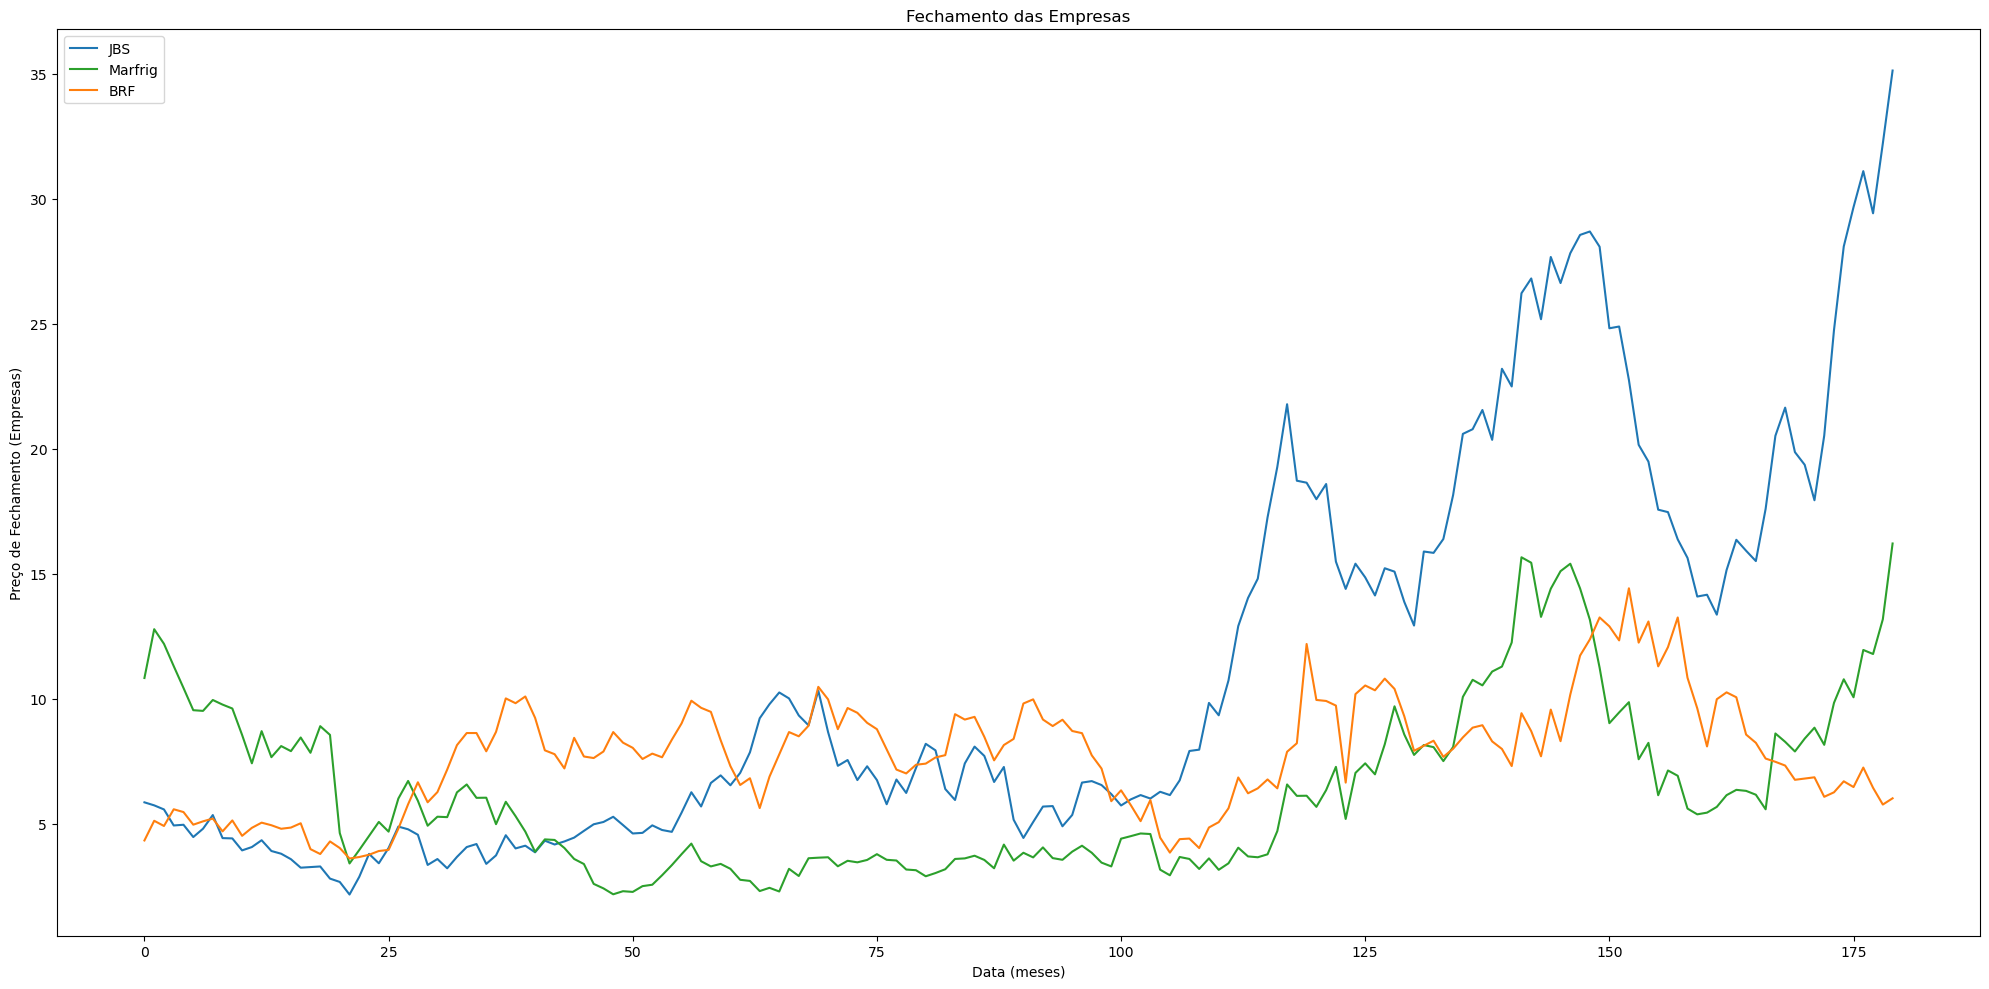

In [9]:
#plot para analisar o historico do preço de fechamento das empresas no primeiro dia util de cada mes
fig, ax = plt.subplots(figsize=(20, 10))

#eixo 1: Linhas para empresas
ax.plot(range(len(df_marfrig)), df_jbs.close_jbs, color='#1f77b4', label='JBS')
ax.plot(range(len(df_marfrig)), df_marfrig.close_marfrig, color='#2ca02c', label='Marfrig')
ax.plot(range(len(df_brf)), df_brf.close_brf, color='#ff7f0e', label='BRF')

ax.set_ylabel("Preço de Fechamento (Empresas)")
ax.set_xlabel("Data (meses)")
ax.legend(loc="upper left")

#título geral
plt.title("Fechamento das Empresas")

plt.tight_layout()
plt.show()

### heatmap de correlação

#### correlação com variações

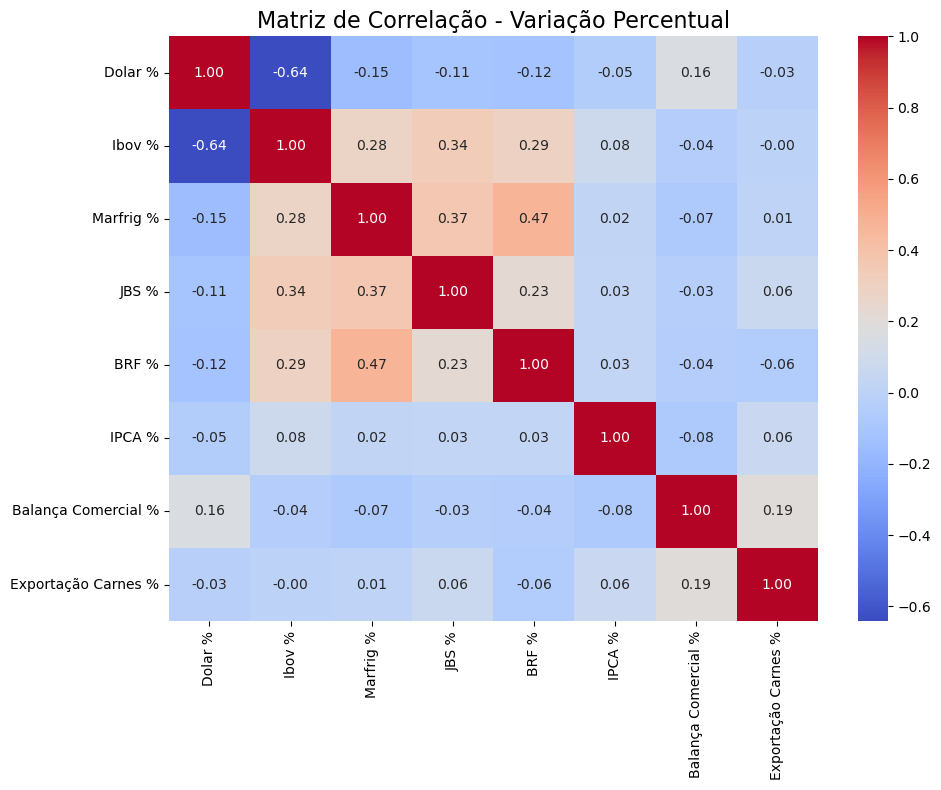

In [10]:
# Remova a coluna 'data'
df_corr_var = df_final_var.drop(['data'], axis=1)

# Se quiser renomear as colunas do DataFrame antes de plotar
novo_nome_colunas = {
    'var_%_dolar': 'Dolar %',
    'var_%_ibov': 'Ibov %',
    'var_%_marfrig': 'Marfrig %',
    'var_%_jbs': 'JBS %',
    'var_%_brf': 'BRF %',
    'var_%_ipca': 'IPCA %',
    'var_%_balanca_com': 'Balança Comercial %',
    'var_%_exp_carnes': 'Exportação Carnes %'
}
df_corr_var = df_corr_var.rename(columns=novo_nome_colunas)

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr_var.corr(), annot=True, cmap="coolwarm", fmt='.2f',
            xticklabels=df_corr_var.columns, yticklabels=df_corr_var.columns)

plt.title("Matriz de Correlação - Variação Percentual", fontsize=16)
plt.tight_layout()
plt.show()


#### correlação com valores

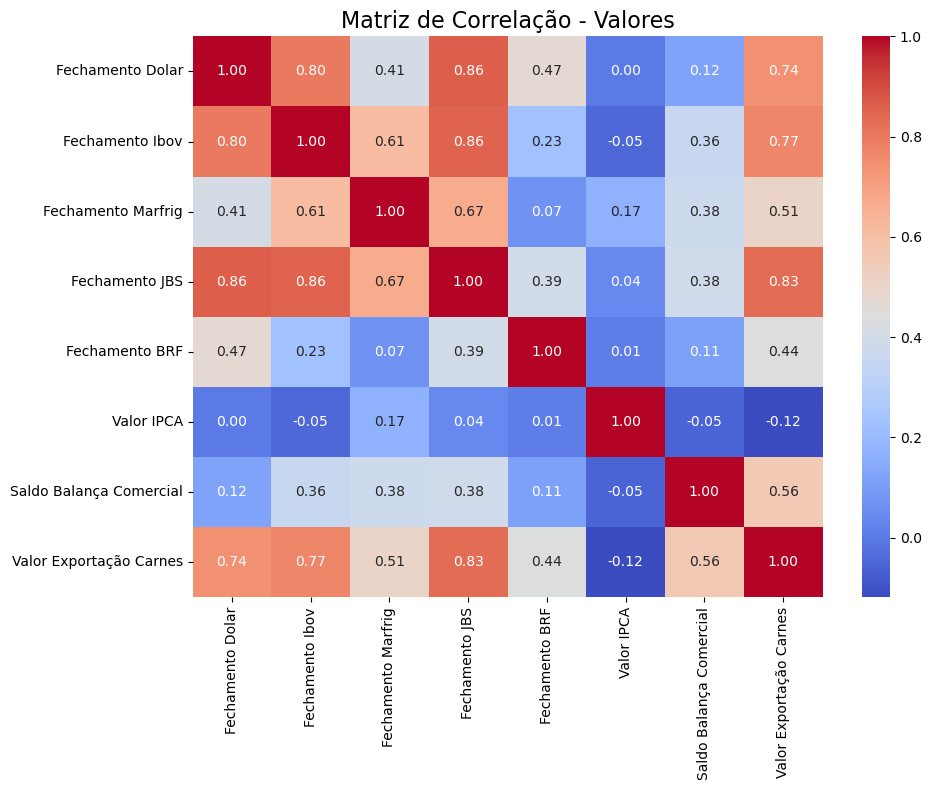

In [11]:
# Remova a coluna 'data'
df_corr_valor = df_final_value.drop(['data'], axis=1)

# Se quiser renomear as colunas do DataFrame antes de plotar
novo_nome_colunas = {
    'close_dolar': 'Fechamento Dolar',
    'close_ibov': 'Fechamento Ibov',
    'close_marfrig': 'Fechamento Marfrig',
    'close_jbs': 'Fechamento JBS',
    'close_brf': 'Fechamento BRF',
    'value_ipca': 'Valor IPCA',
    'saldo_balanca_com': 'Saldo Balança Comercial',
    'value_exp_carnes': 'Valor Exportação Carnes'
}
df_corr_valor = df_corr_valor.rename(columns=novo_nome_colunas)

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr_valor.corr(), annot=True, cmap="coolwarm", fmt='.2f',
            xticklabels=df_corr_valor.columns, yticklabels=df_corr_valor.columns)

plt.title("Matriz de Correlação - Valores", fontsize=16)
plt.tight_layout()
plt.show()


### histograma de valores

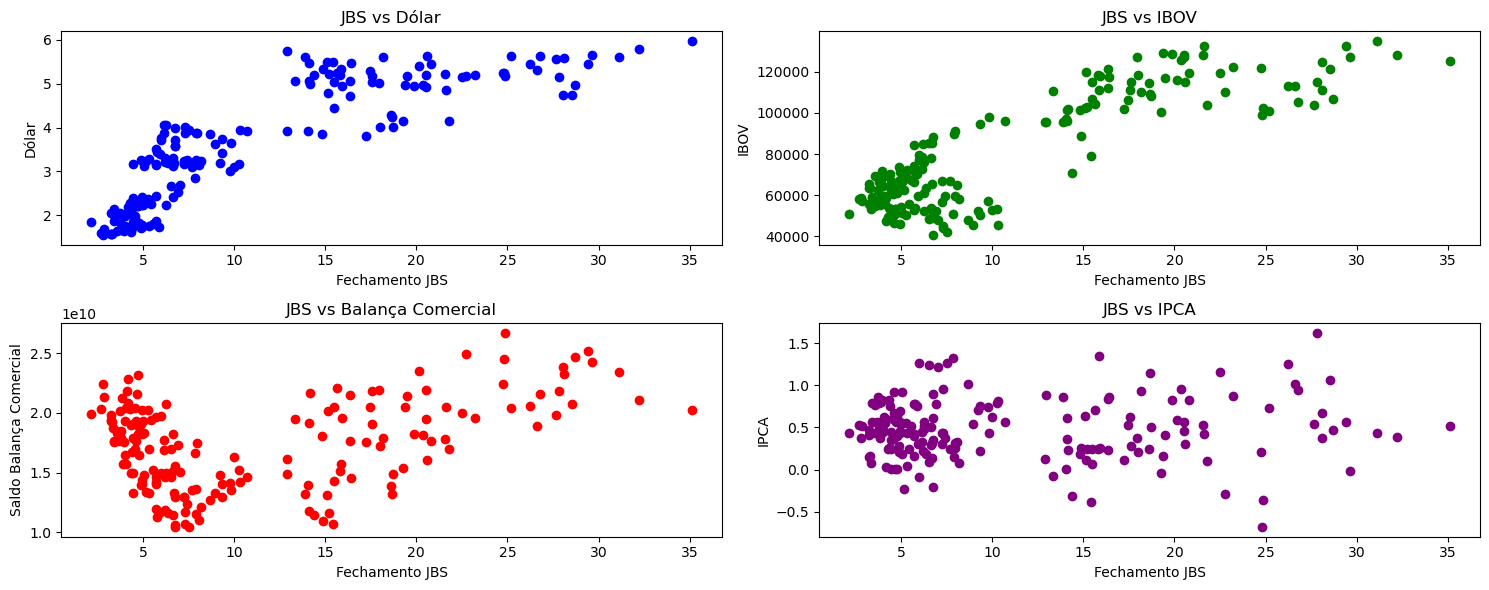

In [12]:
# Criar figura com 2 linhas e 2 colunas (4 gráficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. JBS vs Dólar
ax[0, 0].scatter(df_final_value['close_jbs'], df_final_value['close_dolar'], color='blue')
ax[0, 0].set_title("JBS vs Dólar")
ax[0, 0].set_xlabel("Fechamento JBS")
ax[0, 0].set_ylabel("Dólar")

# 2. JBS vs IBOV
ax[0, 1].scatter(df_final_value['close_jbs'], df_final_value['close_ibov'], color='green')
ax[0, 1].set_title("JBS vs IBOV")
ax[0, 1].set_xlabel("Fechamento JBS")
ax[0, 1].set_ylabel("IBOV")

# 3. JBS vs Balança Comercial
ax[1, 0].scatter(df_final_value['close_jbs'], df_final_value['saldo_balanca_com'], color='red')
ax[1, 0].set_title("JBS vs Balança Comercial")
ax[1, 0].set_xlabel("Fechamento JBS")
ax[1, 0].set_ylabel("Saldo Balança Comercial")

# 4. JBS vs IPCA
ax[1, 1].scatter(df_final_value['close_jbs'], df_final_value['value_ipca'], color='purple')
ax[1, 1].set_title("JBS vs IPCA")
ax[1, 1].set_xlabel("Fechamento JBS")
ax[1, 1].set_ylabel("IPCA")

plt.tight_layout()
plt.show()

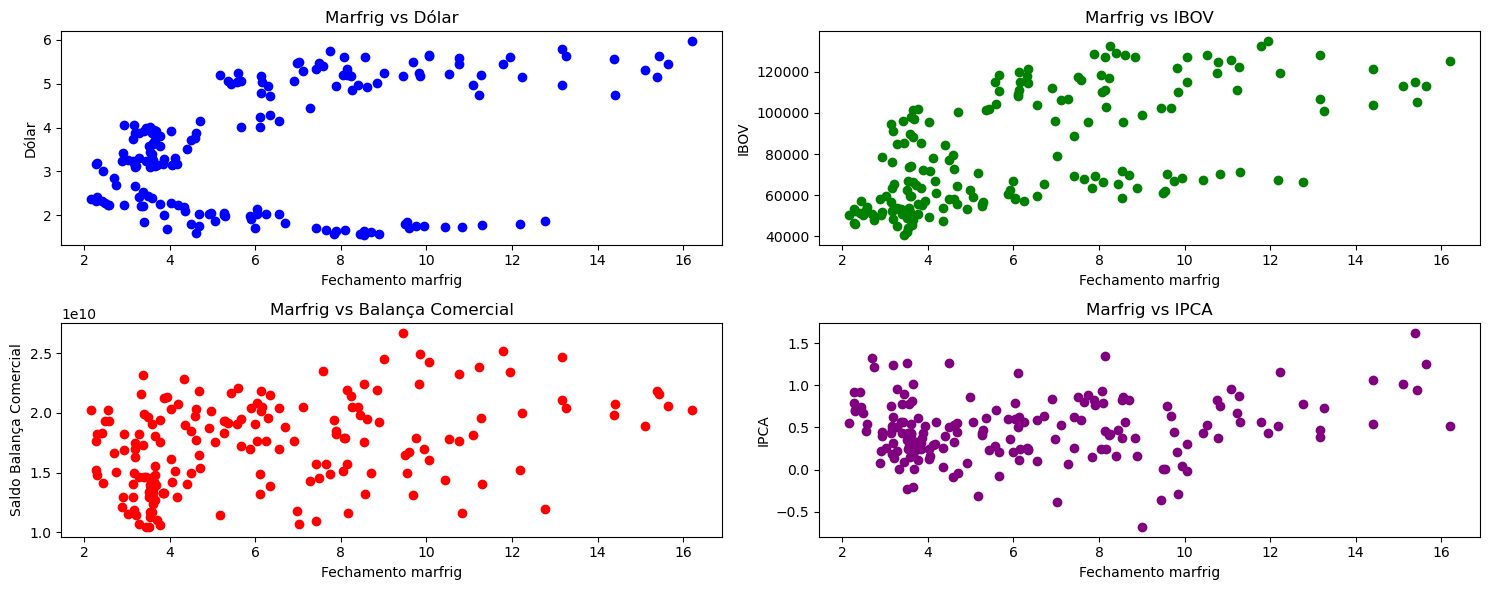

In [13]:
# Criar figura com 2 linhas e 2 colunas (4 gráficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. marfrig vs Dólar
ax[0, 0].scatter(df_final_value['close_marfrig'], df_final_value['close_dolar'], color='blue')
ax[0, 0].set_title("Marfrig vs Dólar")
ax[0, 0].set_xlabel("Fechamento marfrig")
ax[0, 0].set_ylabel("Dólar")

# 2. marfrig vs IBOV
ax[0, 1].scatter(df_final_value['close_marfrig'], df_final_value['close_ibov'], color='green')
ax[0, 1].set_title("Marfrig vs IBOV")
ax[0, 1].set_xlabel("Fechamento marfrig")
ax[0, 1].set_ylabel("IBOV")

# 3. marfrig vs Balança Comercial
ax[1, 0].scatter(df_final_value['close_marfrig'], df_final_value['saldo_balanca_com'], color='red')
ax[1, 0].set_title("Marfrig vs Balança Comercial")
ax[1, 0].set_xlabel("Fechamento marfrig")
ax[1, 0].set_ylabel("Saldo Balança Comercial")

# 4. marfrig vs IPCA
ax[1, 1].scatter(df_final_value['close_marfrig'], df_final_value['value_ipca'], color='purple')
ax[1, 1].set_title("Marfrig vs IPCA")
ax[1, 1].set_xlabel("Fechamento marfrig")
ax[1, 1].set_ylabel("IPCA")

plt.tight_layout()
plt.show()

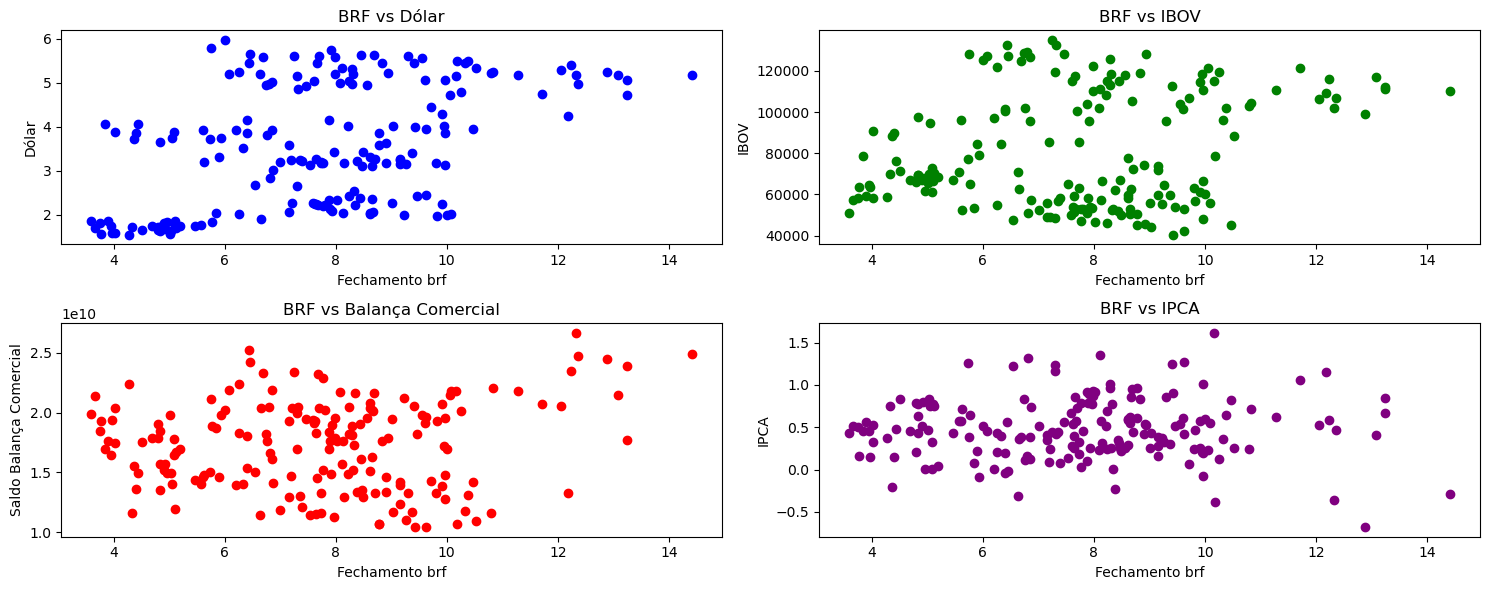

In [14]:
# Criar figura com 2 linhas e 2 colunas (4 gráficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. brf vs Dólar
ax[0, 0].scatter(df_final_value['close_brf'], df_final_value['close_dolar'], color='blue')
ax[0, 0].set_title("BRF vs Dólar")
ax[0, 0].set_xlabel("Fechamento brf")
ax[0, 0].set_ylabel("Dólar")

# 2. brf vs IBOV
ax[0, 1].scatter(df_final_value['close_brf'], df_final_value['close_ibov'], color='green')
ax[0, 1].set_title("BRF vs IBOV")
ax[0, 1].set_xlabel("Fechamento brf")
ax[0, 1].set_ylabel("IBOV")

# 3. brf vs Balança Comercial
ax[1, 0].scatter(df_final_value['close_brf'], df_final_value['saldo_balanca_com'], color='red')
ax[1, 0].set_title("BRF vs Balança Comercial")
ax[1, 0].set_xlabel("Fechamento brf")
ax[1, 0].set_ylabel("Saldo Balança Comercial")

# 4. brf vs IPCA
ax[1, 1].scatter(df_final_value['close_brf'], df_final_value['value_ipca'], color='purple')
ax[1, 1].set_title("BRF vs IPCA")
ax[1, 1].set_xlabel("Fechamento brf")
ax[1, 1].set_ylabel("IPCA")

plt.tight_layout()
plt.show()

### histograma de variação

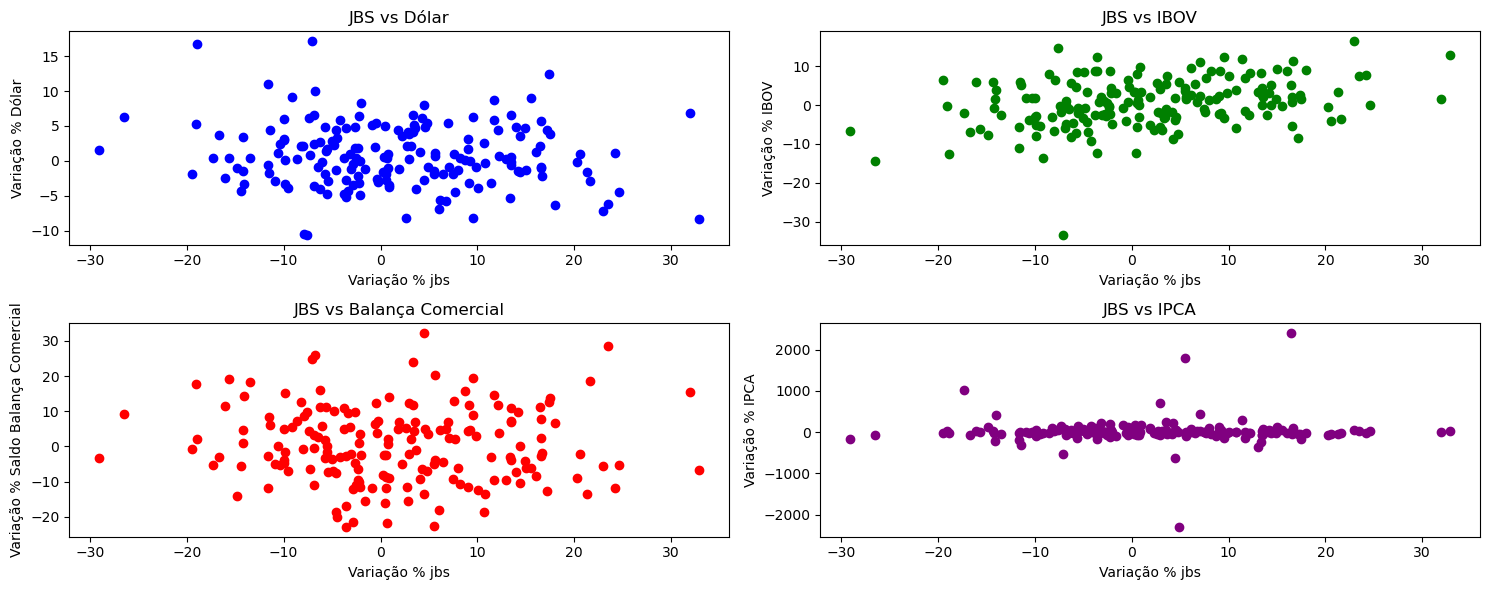

In [15]:
# Criar figura com 2 linhas e 2 colunas (4 gráficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. jbs vs Dólar
ax[0, 0].scatter(df_final_var['var_%_jbs'], df_final_var['var_%_dolar'], color='blue')
ax[0, 0].set_title("JBS vs Dólar")
ax[0, 0].set_xlabel("Variação % jbs")
ax[0, 0].set_ylabel("Variação % Dólar")

# 2. jbs vs IBOV
ax[0, 1].scatter(df_final_var['var_%_jbs'], df_final_var['var_%_ibov'], color='green')
ax[0, 1].set_title("JBS vs IBOV")
ax[0, 1].set_xlabel("Variação % jbs")
ax[0, 1].set_ylabel("Variação % IBOV")

# 3. jbs vs Balança Comercial
ax[1, 0].scatter(df_final_var['var_%_jbs'], df_final_var['var_%_balanca_com'], color='red')
ax[1, 0].set_title("JBS vs Balança Comercial")
ax[1, 0].set_xlabel("Variação % jbs")
ax[1, 0].set_ylabel("Variação % Saldo Balança Comercial")

# 4. jbs vs IPCA
ax[1, 1].scatter(df_final_var['var_%_jbs'], df_final_var['var_%_ipca'], color='purple')
ax[1, 1].set_title("JBS vs IPCA")
ax[1, 1].set_xlabel("Variação % jbs")
ax[1, 1].set_ylabel("Variação % IPCA")

plt.tight_layout()
plt.show()

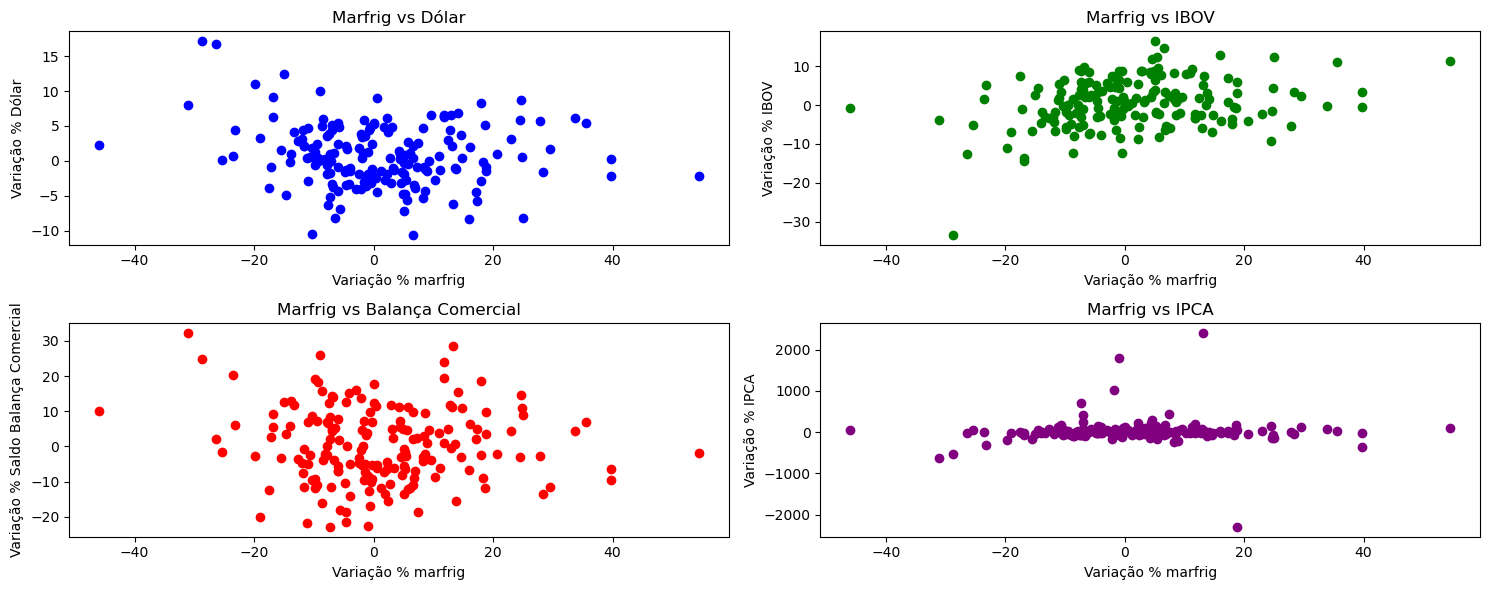

In [16]:
# Criar figura com 2 linhas e 2 colunas (4 gráficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. marfrig vs Dólar
ax[0, 0].scatter(df_final_var['var_%_marfrig'], df_final_var['var_%_dolar'], color='blue')
ax[0, 0].set_title("Marfrig vs Dólar")
ax[0, 0].set_xlabel("Variação % marfrig")
ax[0, 0].set_ylabel("Variação % Dólar")

# 2. marfrig vs IBOV
ax[0, 1].scatter(df_final_var['var_%_marfrig'], df_final_var['var_%_ibov'], color='green')
ax[0, 1].set_title("Marfrig vs IBOV")
ax[0, 1].set_xlabel("Variação % marfrig")
ax[0, 1].set_ylabel("Variação % IBOV")

# 3. marfrig vs Balança Comercial
ax[1, 0].scatter(df_final_var['var_%_marfrig'], df_final_var['var_%_balanca_com'], color='red')
ax[1, 0].set_title("Marfrig vs Balança Comercial")
ax[1, 0].set_xlabel("Variação % marfrig")
ax[1, 0].set_ylabel("Variação % Saldo Balança Comercial")

# 4. marfrig vs IPCA
ax[1, 1].scatter(df_final_var['var_%_marfrig'], df_final_var['var_%_ipca'], color='purple')
ax[1, 1].set_title("Marfrig vs IPCA")
ax[1, 1].set_xlabel("Variação % marfrig")
ax[1, 1].set_ylabel("Variação % IPCA")

plt.tight_layout()
plt.show()

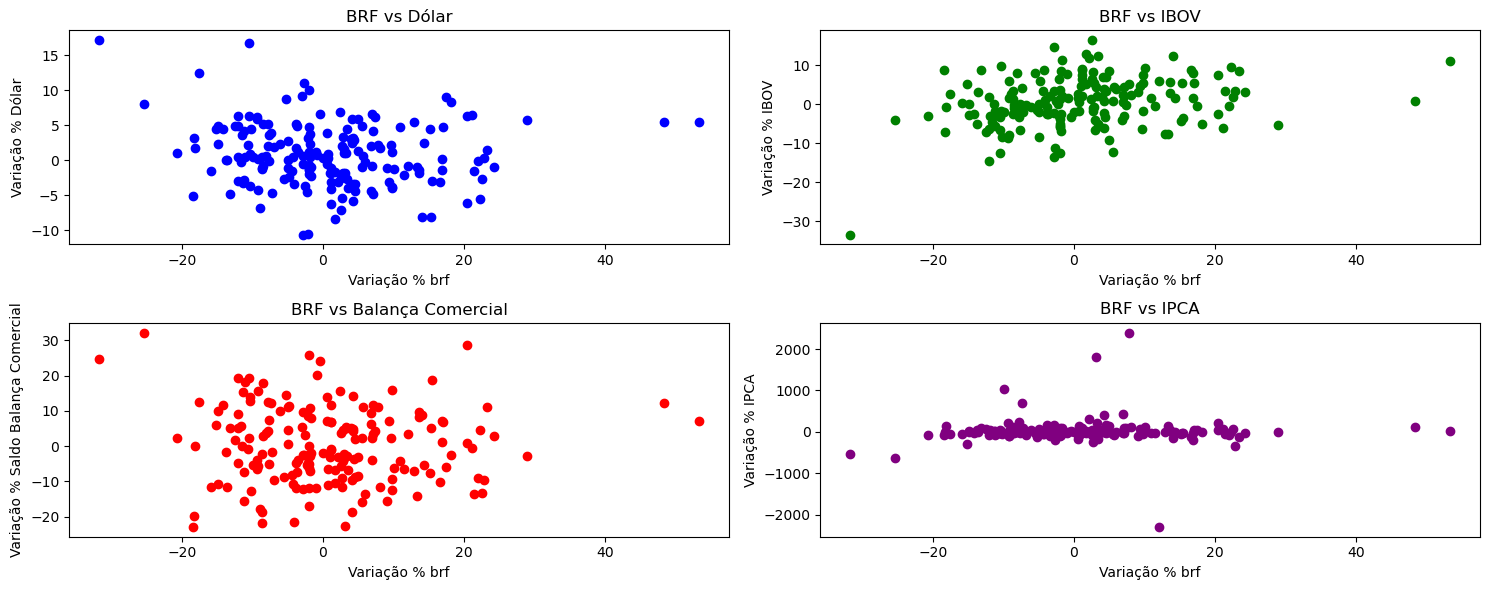

In [17]:
# Criar figura com 2 linhas e 2 colunas (4 gráficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. brf vs Dólar
ax[0, 0].scatter(df_final_var['var_%_brf'], df_final_var['var_%_dolar'], color='blue')
ax[0, 0].set_title("BRF vs Dólar")
ax[0, 0].set_xlabel("Variação % brf")
ax[0, 0].set_ylabel("Variação % Dólar")

# 2. brf vs IBOV
ax[0, 1].scatter(df_final_var['var_%_brf'], df_final_var['var_%_ibov'], color='green')
ax[0, 1].set_title("BRF vs IBOV")
ax[0, 1].set_xlabel("Variação % brf")
ax[0, 1].set_ylabel("Variação % IBOV")

# 3. brf vs Balança Comercial
ax[1, 0].scatter(df_final_var['var_%_brf'], df_final_var['var_%_balanca_com'], color='red')
ax[1, 0].set_title("BRF vs Balança Comercial")
ax[1, 0].set_xlabel("Variação % brf")
ax[1, 0].set_ylabel("Variação % Saldo Balança Comercial")

# 4. brf vs IPCA
ax[1, 1].scatter(df_final_var['var_%_brf'], df_final_var['var_%_ipca'], color='purple')
ax[1, 1].set_title("BRF vs IPCA")
ax[1, 1].set_xlabel("Variação % brf")
ax[1, 1].set_ylabel("Variação % IPCA")

plt.tight_layout()
plt.show()

### Análise empresas x valor de exportação de carne

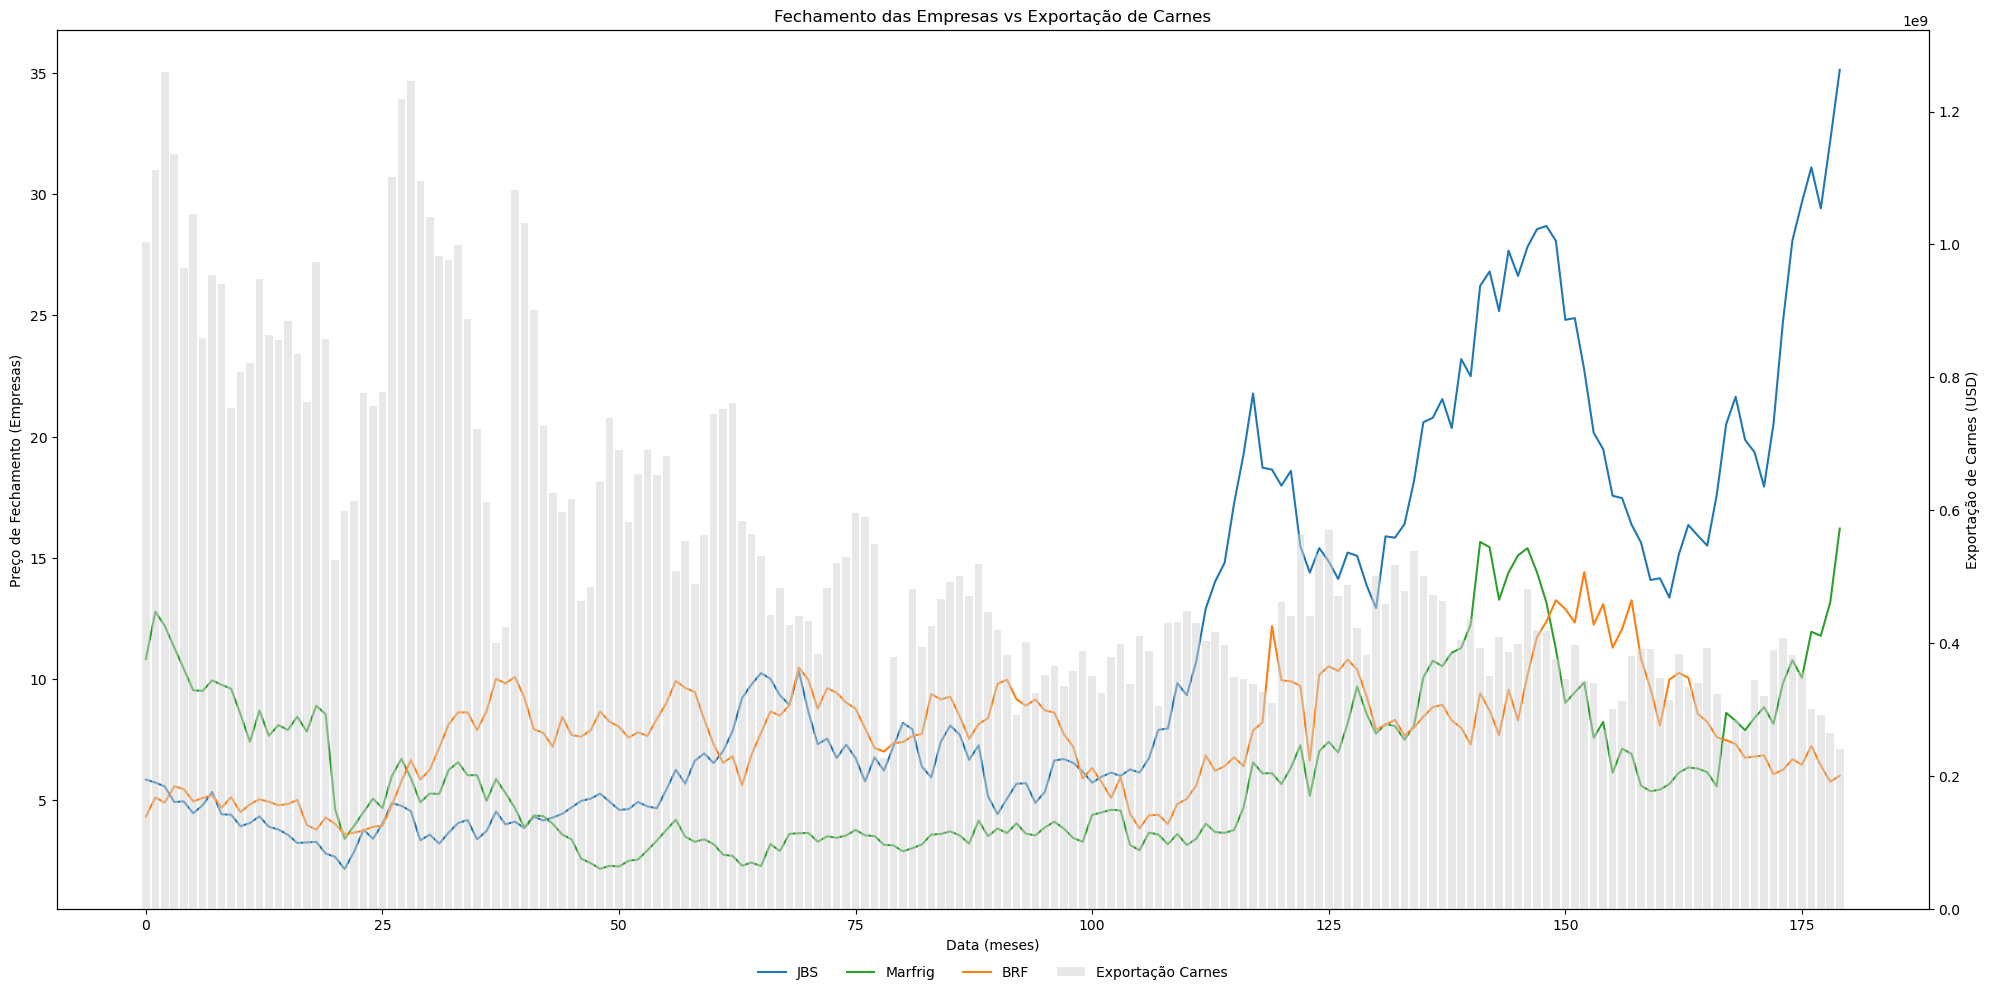

In [18]:
fig, ax1 = plt.subplots(figsize=(20, 10))

#eixo 2: Barras para exportações
ax2 = ax1.twinx()
ax2.bar(
    range(len(df_balanca_carnes)),
    df_balanca_carnes.value_exp_carnes,
    alpha=0.5,
    color='#d3d3d3',
    label='Exportação Carnes'
)
ax2.set_ylabel("Exportação de Carnes (USD)")

#eixo 1: Linhas para empresas
ax1.plot(range(len(df_jbs)), df_jbs.close_jbs, color='#1f77b4', label='JBS')
ax1.plot(range(len(df_marfrig)), df_marfrig.close_marfrig, color='#2ca02c', label='Marfrig')
ax1.plot(range(len(df_brf)), df_brf.close_brf, color='#ff7f0e', label='BRF')

ax1.set_ylabel("Preço de Fechamento (Empresas)")
ax1.set_xlabel("Data (meses)")
ax1.legend(loc="upper left")

#título geral
plt.title("Fechamento das Empresas vs Exportação de Carnes")

#legendas combinadas (manual)
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
ax1.legend(
    lines_labels,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),  # centralizado e abaixo do gráfico
    ncol=4,                       # 4 colunas na legenda (ajuste conforme necessário)
    frameon=False                 # remove a borda da legenda (opcional)
)

plt.tight_layout()
plt.show()


## Modelo de regressão linear valores

### separar dados em treino e teste para cada empresa

In [19]:
#separar os dados de entrada e os 3 alvos
X = df_final_value.drop(columns=['data', 'close_marfrig', 'close_jbs', 'close_brf', 'value_exp_carnes'])

y_jbs = df_final_value['close_jbs']
y_marfrig = df_final_value['close_marfrig']
y_brf = df_final_value['close_brf']

#fazer apenas UMA divisão (split) e use os mesmos índices para todos os y
X_train, X_test, idx_train, idx_test = train_test_split(X, X.index, test_size=0.25, random_state=42)

#dividir os alvos com os mesmos índices
y_jbs_train = y_jbs.loc[idx_train]
y_jbs_test = y_jbs.loc[idx_test]

y_marfrig_train = y_marfrig.loc[idx_train]
y_marfrig_test = y_marfrig.loc[idx_test]

y_brf_train = y_brf.loc[idx_train]
y_brf_test = y_brf.loc[idx_test]

In [20]:
# Renomear as colunas antes de dividir (se quiser que tudo já venha renomeado)
df_final_value = df_final_value.rename(columns={
    'close_dolar': 'Fechamento Dolar',
    'close_ibov': 'Fechamento Ibov',
    'close_marfrig': 'Fechamento Marfrig',
    'close_jbs': 'Fechamento JBS',
    'close_brf': 'Fechamento BRF',
    'value_ipca': 'Valor IPCA',
    'saldo_balanca_com': 'Saldo Balança Comercial',
    'value_exp_carnes': 'Valor Exportação Carnes'
})

X = df_final_value.drop(columns=['data', 'Fechamento Marfrig', 'Fechamento JBS', 'Fechamento BRF', 'Valor Exportação Carnes'])

y_jbs = df_final_value['Fechamento JBS']
y_marfrig = df_final_value['Fechamento Marfrig']
y_brf = df_final_value['Fechamento BRF']

X_train, X_test, idx_train, idx_test = train_test_split(X, X.index, test_size=0.25, random_state=42)

y_jbs_train = y_jbs.loc[idx_train]
y_jbs_test = y_jbs.loc[idx_test]

y_marfrig_train = y_marfrig.loc[idx_train]
y_marfrig_test = y_marfrig.loc[idx_test]

y_brf_train = y_brf.loc[idx_train]
y_brf_test = y_brf.loc[idx_test]


### regressão linear simples


🔹🔹🔹 Regressão Linear Simples para JBS 🔹🔹🔹

📈 Variável: Fechamento Dolar
  R² teste: 0.6360
  EMA: 3.78
  EQM: 21.11

📈 Variável: Fechamento Ibov
  R² teste: 0.7125
  EMA: 3.39
  EQM: 16.68

📈 Variável: Valor IPCA
  R² teste: -0.0424
  EMA: 6.69
  EQM: 60.46

📈 Variável: Saldo Balança Comercial
  R² teste: 0.1261
  EMA: 5.74
  EQM: 50.69


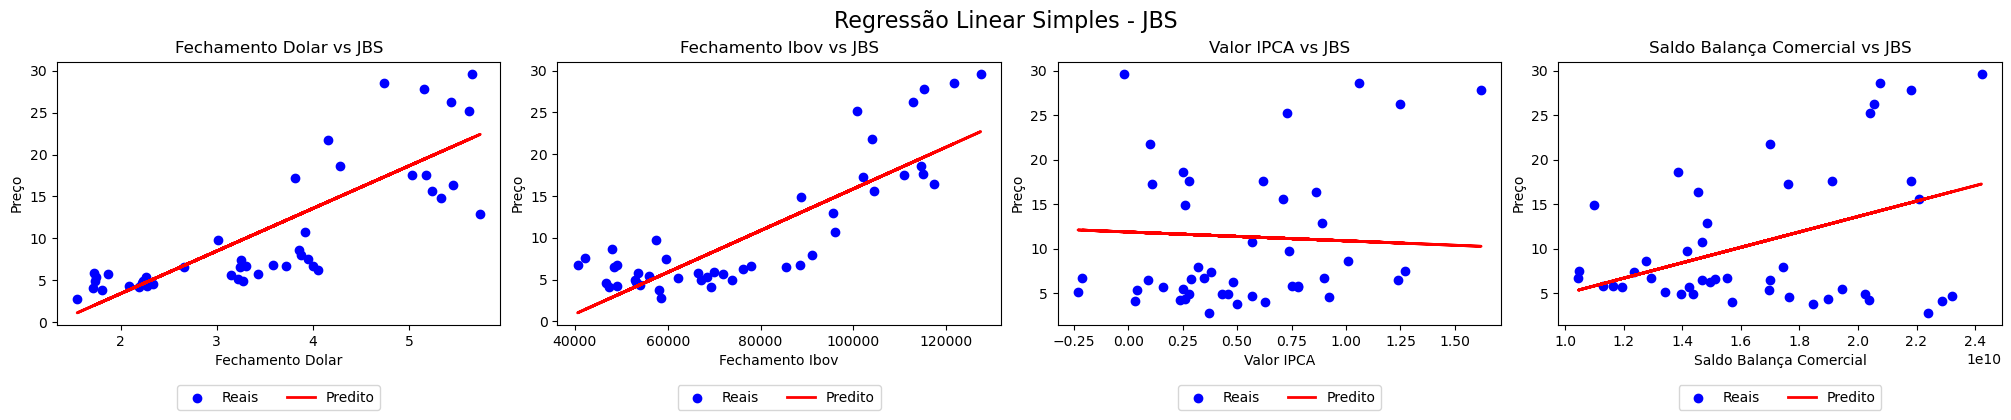


🔹🔹🔹 Regressão Linear Simples para Marfrig 🔹🔹🔹

📈 Variável: Fechamento Dolar
  R² teste: 0.0665
  EMA: 2.94
  EQM: 12.60

📈 Variável: Fechamento Ibov
  R² teste: 0.2823
  EMA: 2.36
  EQM: 9.69

📈 Variável: Valor IPCA
  R² teste: 0.0511
  EMA: 3.01
  EQM: 12.81

📈 Variável: Saldo Balança Comercial
  R² teste: 0.0489
  EMA: 2.88
  EQM: 12.84


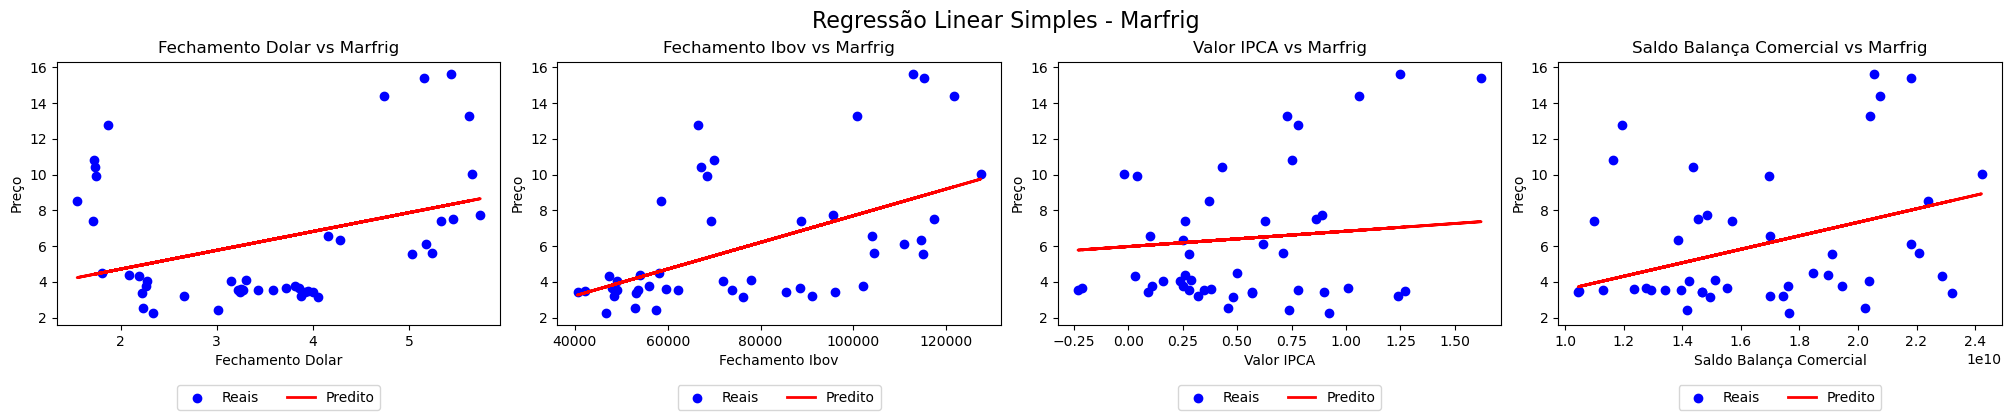


🔹🔹🔹 Regressão Linear Simples para BRF 🔹🔹🔹

📈 Variável: Fechamento Dolar
  R² teste: 0.2506
  EMA: 1.53
  EQM: 3.17

📈 Variável: Fechamento Ibov
  R² teste: 0.0343
  EMA: 1.69
  EQM: 4.09

📈 Variável: Valor IPCA
  R² teste: -0.0924
  EMA: 1.69
  EQM: 4.62

📈 Variável: Saldo Balança Comercial
  R² teste: -0.0123
  EMA: 1.68
  EQM: 4.29


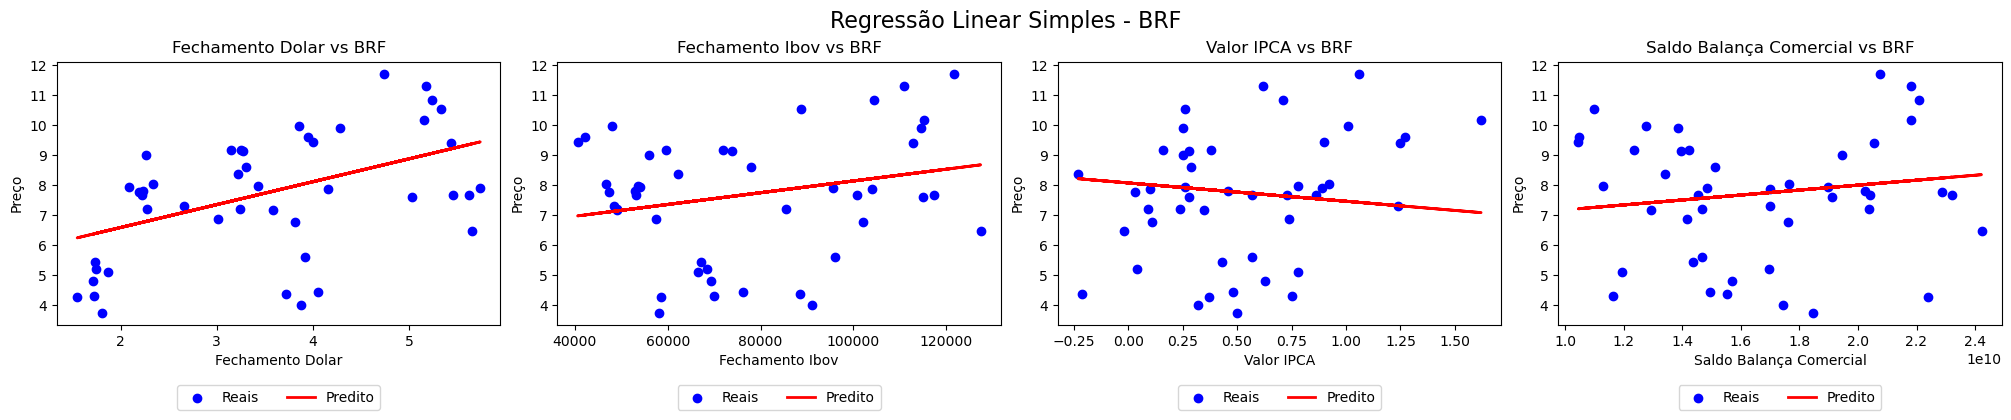

In [21]:

# Dicionário com os dados de cada empresa
empresas = {
    'JBS': (y_jbs_train, y_jbs_test),
    'Marfrig': (y_marfrig_train, y_marfrig_test),
    'BRF': (y_brf_train, y_brf_test)
}

# Para cada empresa
for nome_empresa, (y_train, y_test) in empresas.items():
    print(f"\n🔹🔹🔹 Regressão Linear Simples para {nome_empresa} 🔹🔹🔹")

    variaveis = X_train.columns.tolist()
    n_vars = len(variaveis)

    # Criar subplots (1 linha, n colunas)
    fig, axs = plt.subplots(1, n_vars, figsize=(5 * n_vars, 4), constrained_layout=True)

    for i, col in enumerate(variaveis):
        X_s_train = X_train[[col]]
        X_s_test = X_test[[col]]

        modelo = LinearRegression().fit(X_s_train, y_train)
        y_pred = modelo.predict(X_s_test)

        # Avaliação
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        print(f"\n📈 Variável: {col}")
        print(f"  R² teste: {r2:.4f}")
        print(f"  EMA: {mae:.2f}")
        print(f"  EQM: {mse:.2f}")

        # Plot no subplot correspondente
        ax = axs[i]
        ax.scatter(X_s_test, y_test, color='blue', label='Reais')
        ax.plot(X_s_test, y_pred, color='red', linewidth=2, label='Predito')
        ax.set_xlabel(col)
        ax.set_ylabel("Preço")
        ax.set_title(f"{col} vs {nome_empresa}")
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)

    # Título geral
    fig.suptitle(f"Regressão Linear Simples - {nome_empresa}", fontsize=16)
    plt.show()


### regressao linear multipla


🔷🔷🔷 Regressão Linear Múltipla para JBS 🔷🔷🔷

📈 JBS - Variáveis: ('Fechamento Dolar', 'Fechamento Ibov')
  R² treino: 82.87%
  R² teste: 77.38%
  EMA: 2.86
  EQM: 13.12

📈 JBS - Variáveis: ('Fechamento Dolar', 'Valor IPCA')
  R² treino: 77.26%
  R² teste: 63.85%
  EMA: 3.78
  EQM: 20.97

📈 JBS - Variáveis: ('Fechamento Dolar', 'Saldo Balança Comercial')
  R² treino: 84.90%
  R² teste: 73.25%
  EMA: 3.22
  EQM: 15.52

📈 JBS - Variáveis: ('Fechamento Ibov', 'Valor IPCA')
  R² treino: 73.68%
  R² teste: 71.79%
  EMA: 3.37
  EQM: 16.36

📈 JBS - Variáveis: ('Fechamento Ibov', 'Saldo Balança Comercial')
  R² treino: 74.35%
  R² teste: 72.13%
  EMA: 3.28
  EQM: 16.16

📈 JBS - Variáveis: ('Valor IPCA', 'Saldo Balança Comercial')
  R² treino: 15.14%
  R² teste: 10.93%
  EMA: 5.81
  EQM: 51.66

📈 JBS - Variáveis: ('Fechamento Dolar', 'Fechamento Ibov', 'Valor IPCA')
  R² treino: 82.95%
  R² teste: 78.22%
  EMA: 2.83
  EQM: 12.63

📈 JBS - Variáveis: ('Fechamento Dolar', 'Fechamento Ibov', 'Saldo B

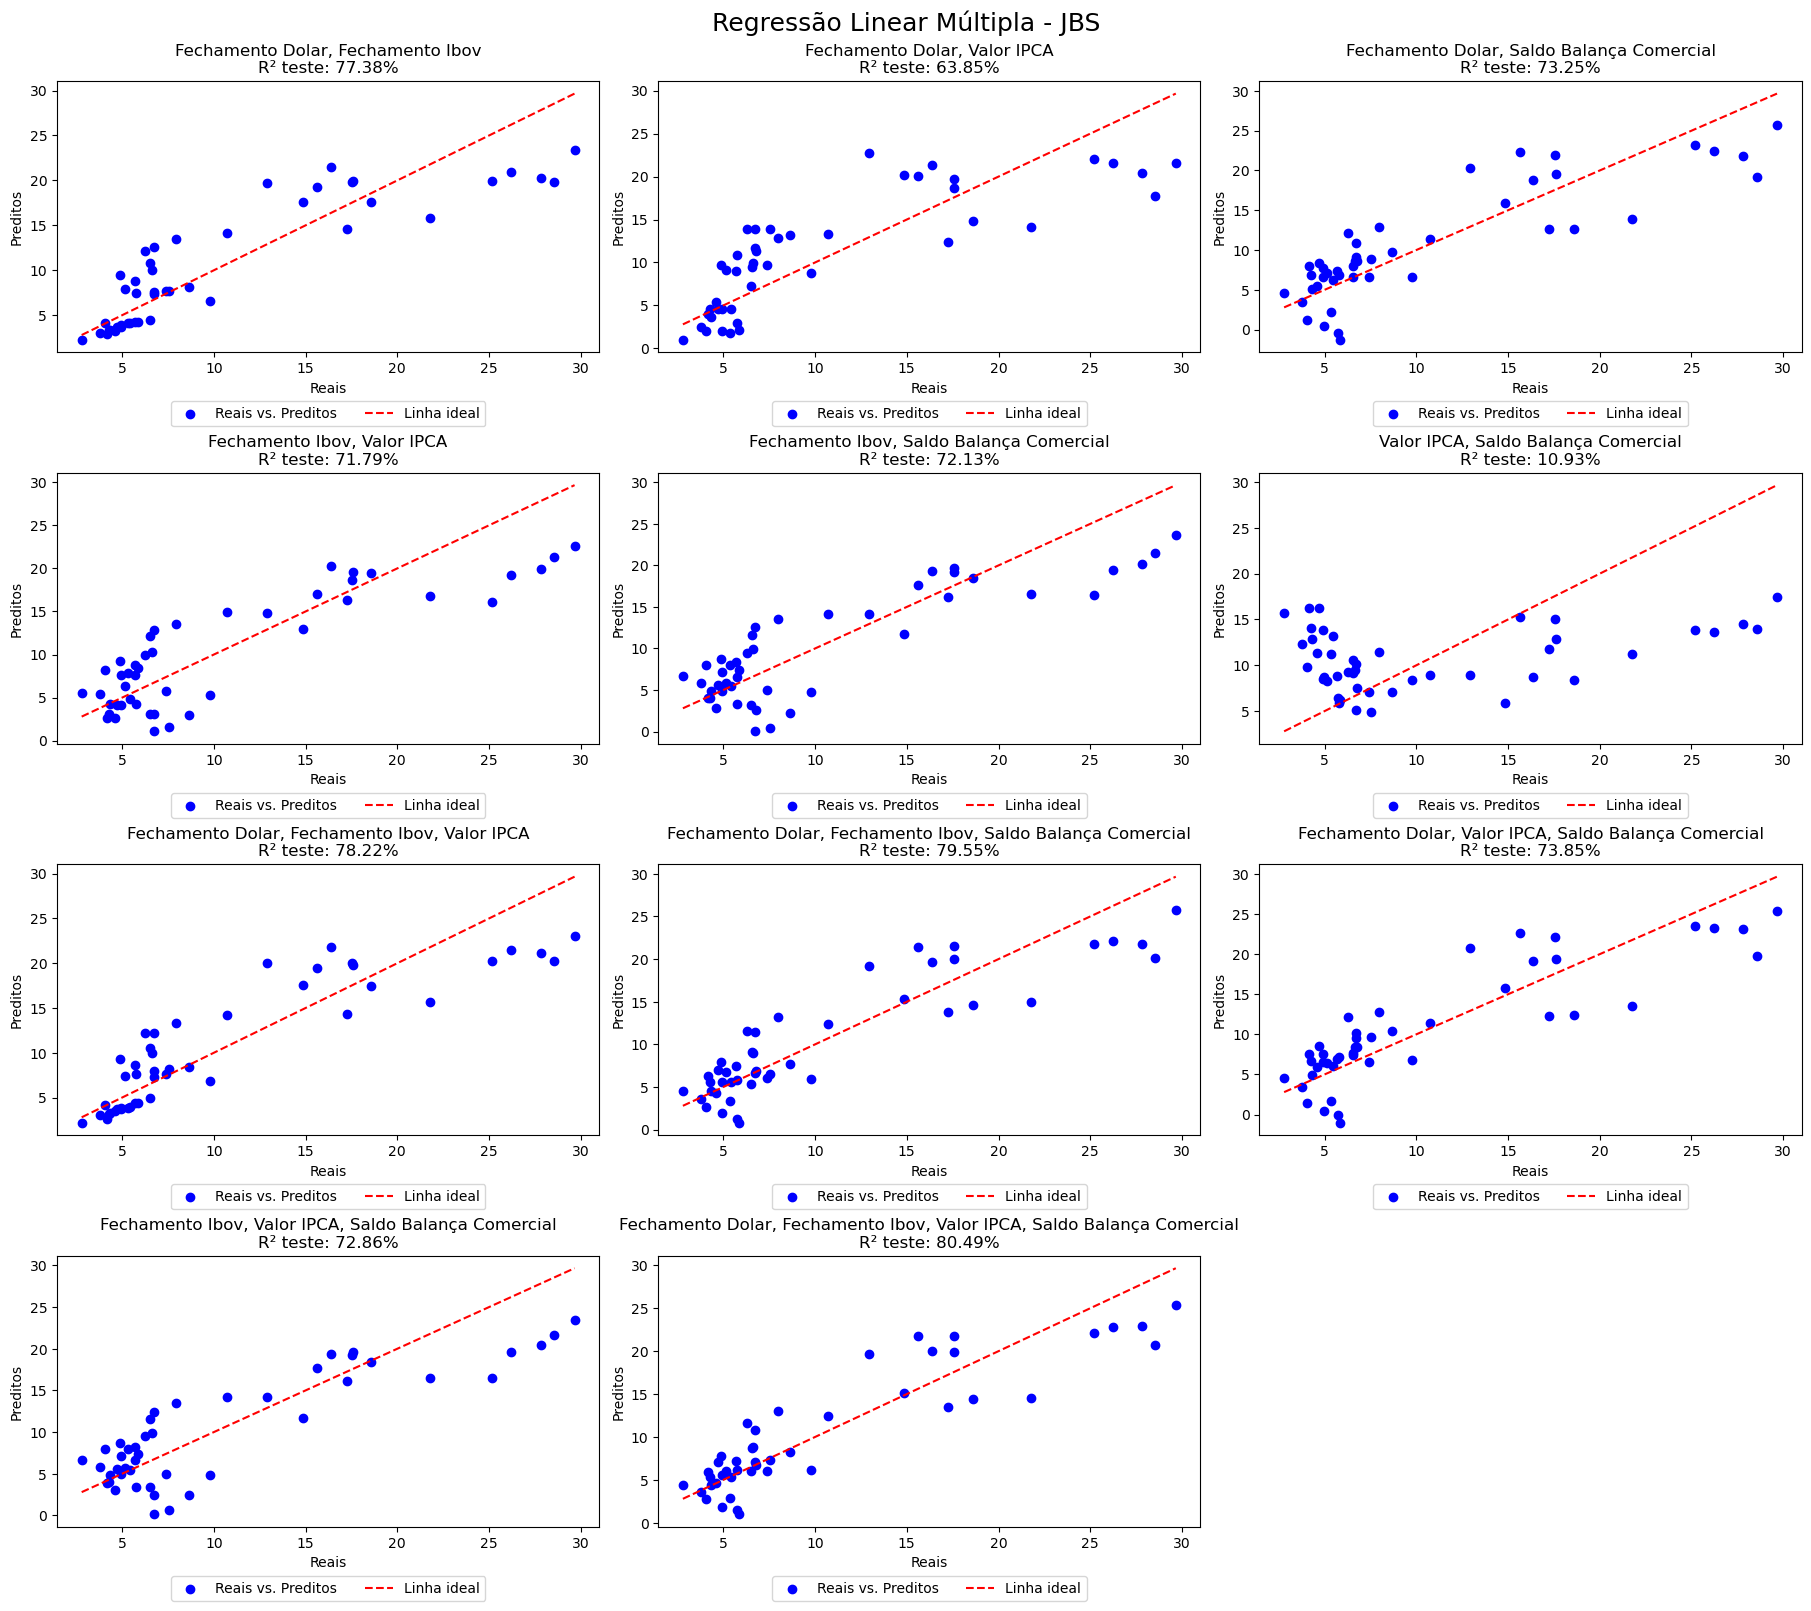


🔷🔷🔷 Regressão Linear Múltipla para Marfrig 🔷🔷🔷

📈 Marfrig - Variáveis: ('Fechamento Dolar', 'Fechamento Ibov')
  R² treino: 43.07%
  R² teste: 30.77%
  EMA: 2.37
  EQM: 9.34

📈 Marfrig - Variáveis: ('Fechamento Dolar', 'Valor IPCA')
  R² treino: 22.58%
  R² teste: 11.81%
  EMA: 2.88
  EQM: 11.90

📈 Marfrig - Variáveis: ('Fechamento Dolar', 'Saldo Balança Comercial')
  R² treino: 34.58%
  R² teste: 11.73%
  EMA: 2.68
  EQM: 11.91

📈 Marfrig - Variáveis: ('Fechamento Ibov', 'Valor IPCA')
  R² treino: 43.11%
  R² teste: 36.16%
  EMA: 2.32
  EQM: 8.62

📈 Marfrig - Variáveis: ('Fechamento Ibov', 'Saldo Balança Comercial')
  R² treino: 45.67%
  R² teste: 28.01%
  EMA: 2.41
  EQM: 9.72

📈 Marfrig - Variáveis: ('Valor IPCA', 'Saldo Balança Comercial')
  R² treino: 19.37%
  R² teste: 12.29%
  EMA: 2.82
  EQM: 11.84

📈 Marfrig - Variáveis: ('Fechamento Dolar', 'Fechamento Ibov', 'Valor IPCA')
  R² treino: 44.53%
  R² teste: 39.31%
  EMA: 2.25
  EQM: 8.19

📈 Marfrig - Variáveis: ('Fechamento Dol

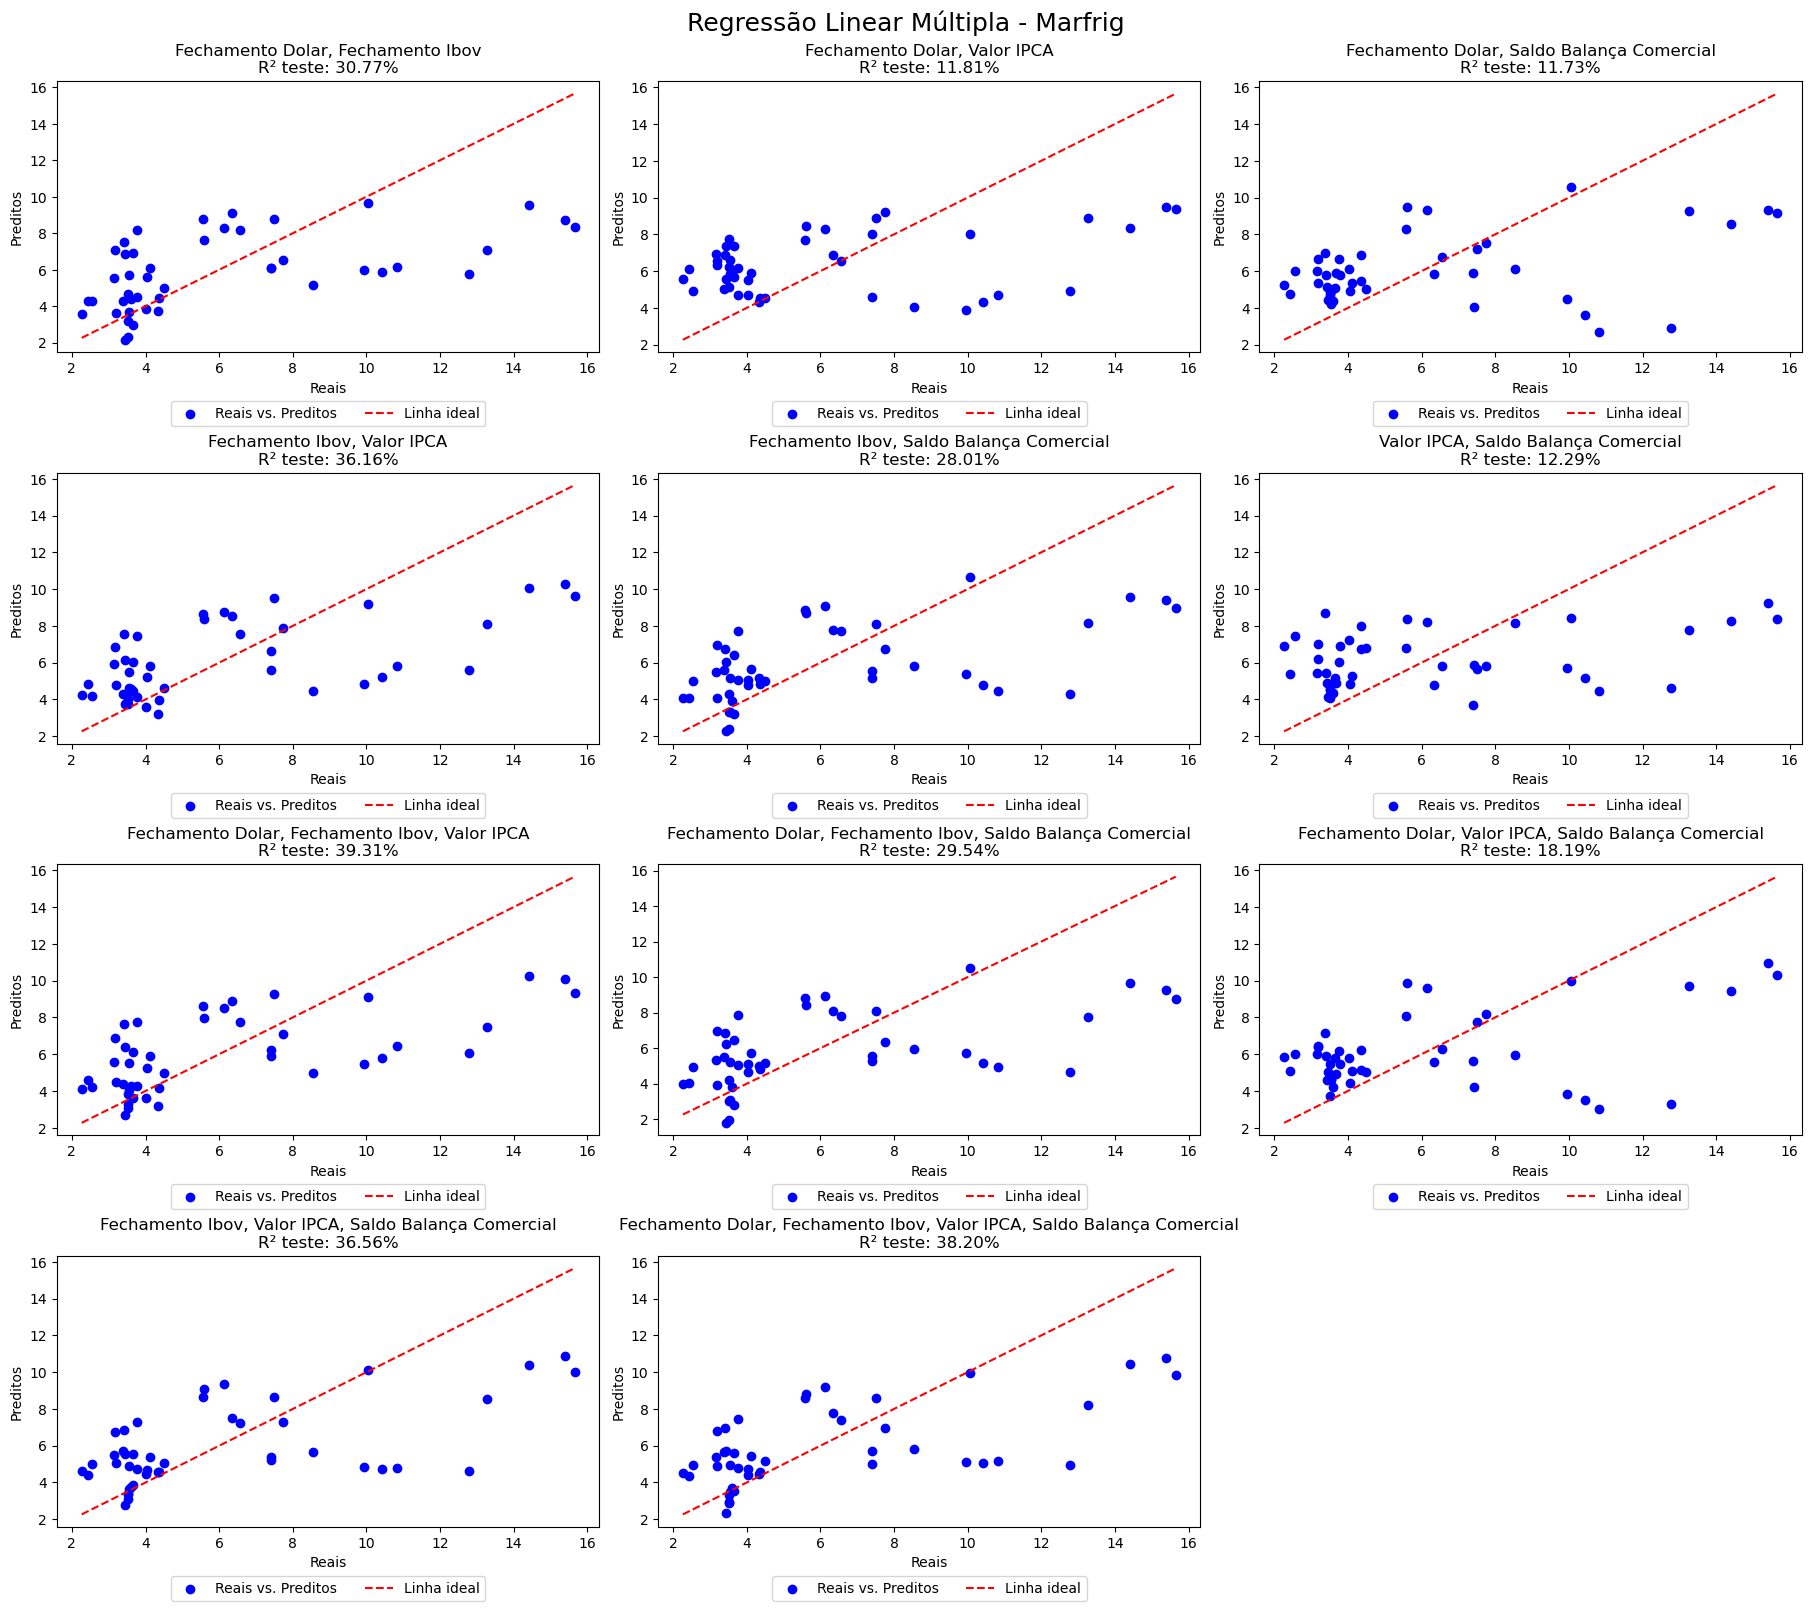


🔷🔷🔷 Regressão Linear Múltipla para BRF 🔷🔷🔷

📈 BRF - Variáveis: ('Fechamento Dolar', 'Fechamento Ibov')
  R² treino: 27.82%
  R² teste: 30.66%
  EMA: 1.35
  EQM: 2.93

📈 BRF - Variáveis: ('Fechamento Dolar', 'Valor IPCA')
  R² treino: 21.67%
  R² teste: 22.05%
  EMA: 1.57
  EQM: 3.30

📈 BRF - Variáveis: ('Fechamento Dolar', 'Saldo Balança Comercial')
  R² treino: 21.91%
  R² teste: 24.64%
  EMA: 1.53
  EQM: 3.19

📈 BRF - Variáveis: ('Fechamento Ibov', 'Valor IPCA')
  R² treino: 6.17%
  R² teste: -3.67%
  EMA: 1.74
  EQM: 4.39

📈 BRF - Variáveis: ('Fechamento Ibov', 'Saldo Balança Comercial')
  R² treino: 5.80%
  R² teste: 2.99%
  EMA: 1.68
  EQM: 4.11

📈 BRF - Variáveis: ('Valor IPCA', 'Saldo Balança Comercial')
  R² treino: 2.40%
  R² teste: -9.18%
  EMA: 1.75
  EQM: 4.62

📈 BRF - Variáveis: ('Fechamento Dolar', 'Fechamento Ibov', 'Valor IPCA')
  R² treino: 28.04%
  R² teste: 29.23%
  EMA: 1.36
  EQM: 3.00

📈 BRF - Variáveis: ('Fechamento Dolar', 'Fechamento Ibov', 'Saldo Balança Come

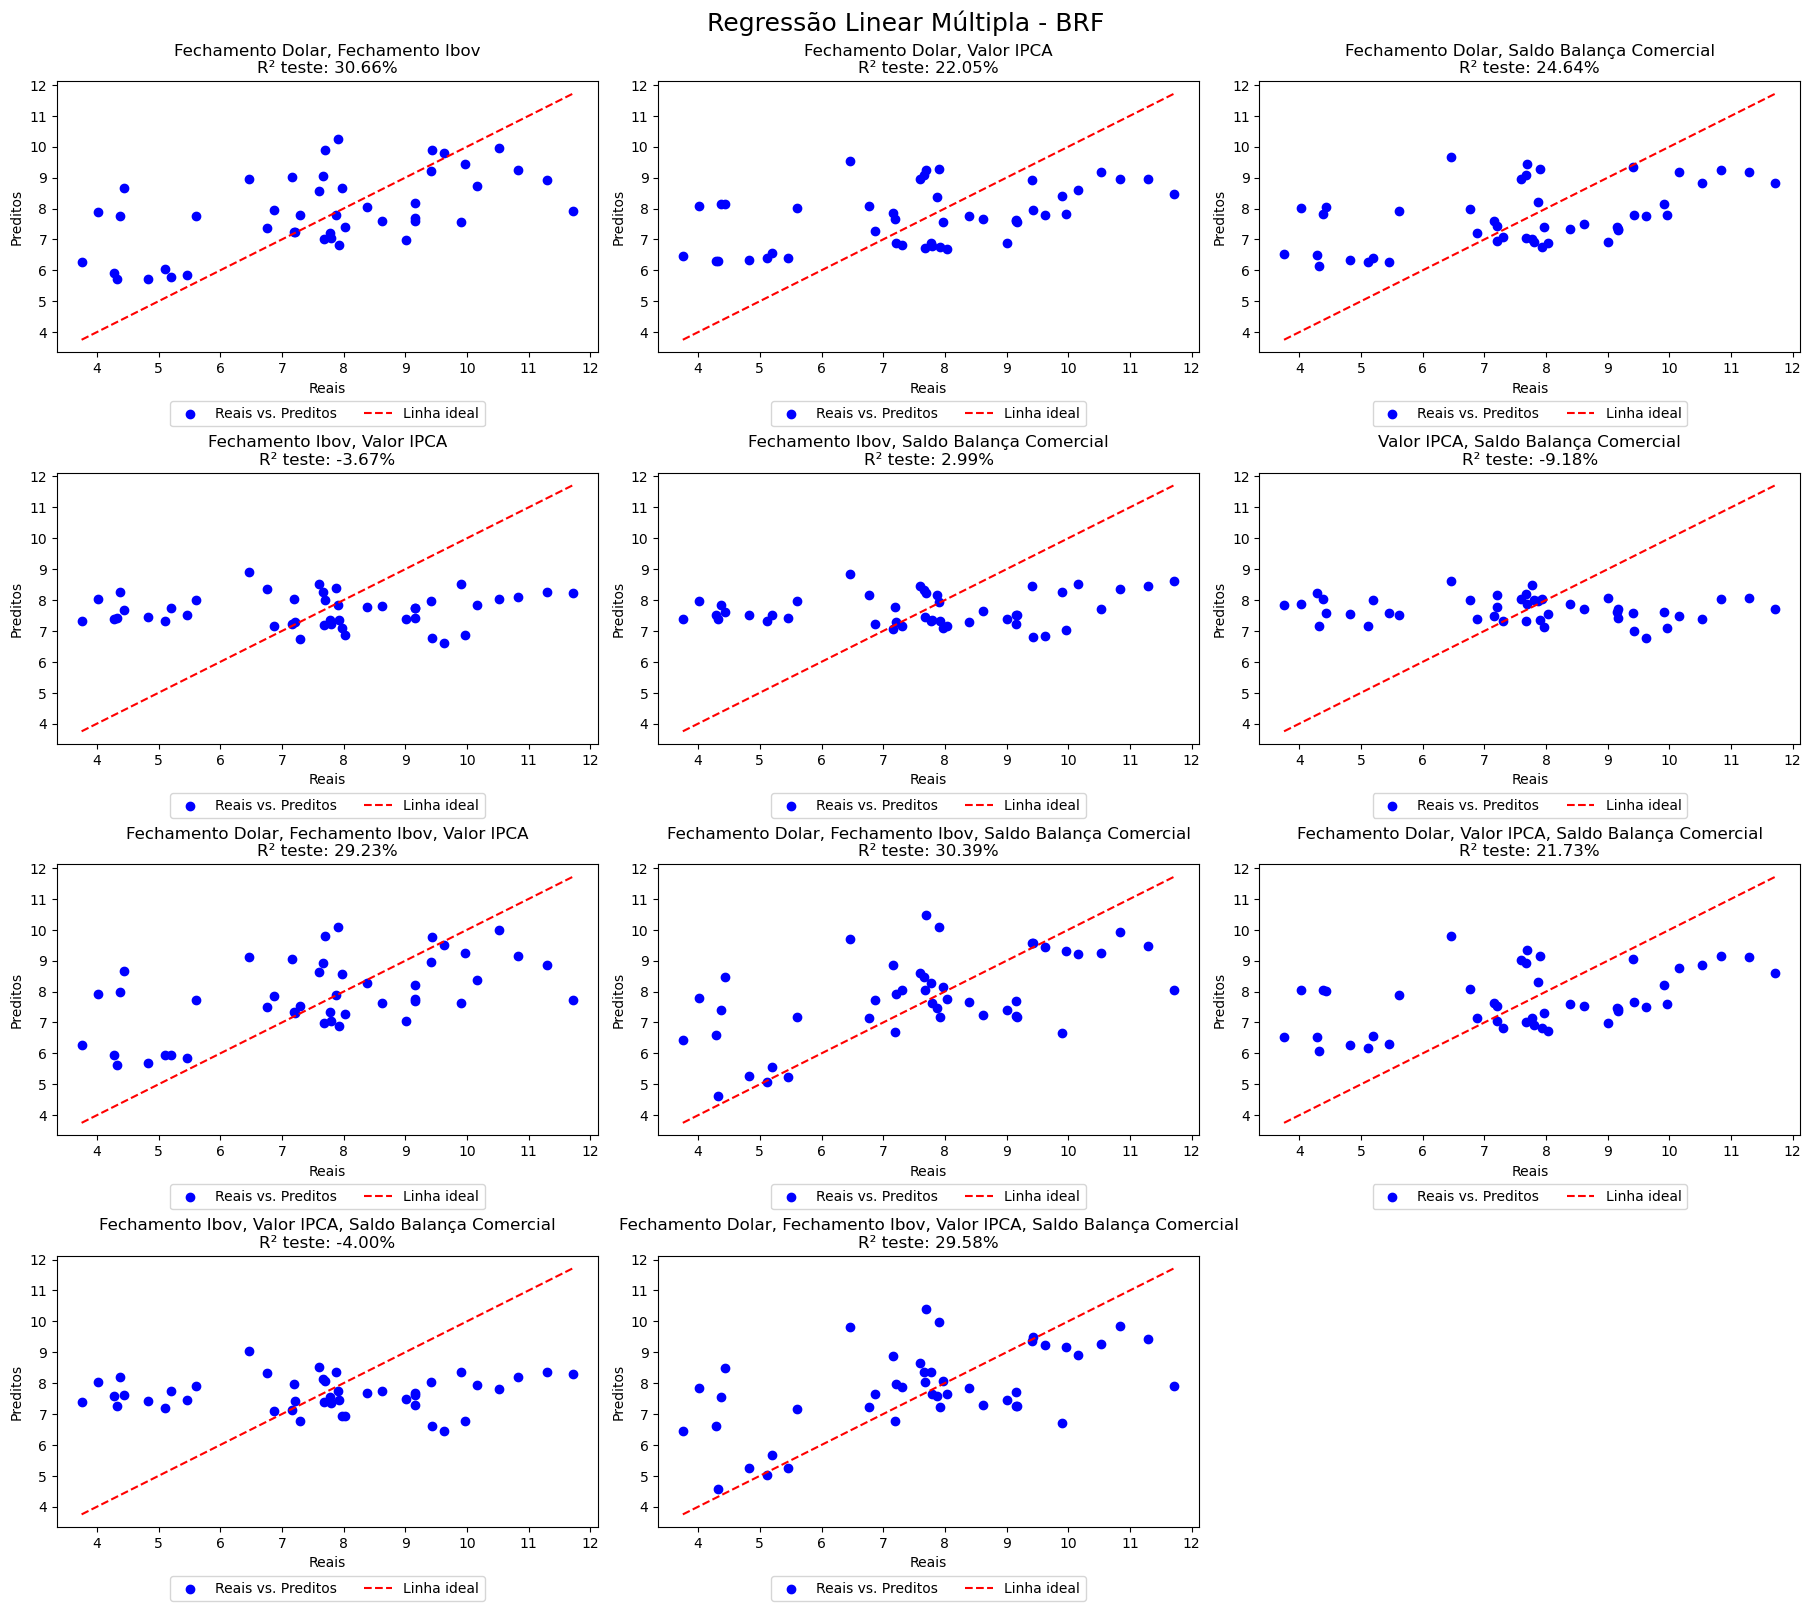

In [22]:
#dados de saída de cada empresa
empresas = {
    'JBS': (y_jbs_train, y_jbs_test),
    'Marfrig': (y_marfrig_train, y_marfrig_test),
    'BRF': (y_brf_train, y_brf_test)
}

#loop para cada empresa
for nome_empresa, (y_train, y_test) in empresas.items():
    print(f"\n🔷🔷🔷 Regressão Linear Múltipla para {nome_empresa} 🔷🔷🔷")

    #gerar todas as combinações de 2 a 4 variáveis
    combinacoes = []
    for k in range(2, len(X_train.columns) + 1):
        combinacoes.extend(list(combinations(X_train.columns, k)))

    n_combos = len(combinacoes)
    n_cols = 3  # número de gráficos por linha
    n_rows = math.ceil(n_combos / n_cols)

    # Criar subplots para todos os gráficos dessa empresa
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), constrained_layout=True)
    axs = axs.flatten()  # achata a matriz para indexação simples

    #loop pelas combinações
    for idx, combo in enumerate(combinacoes):
        X_mult_train = X_train[list(combo)]
        X_mult_test = X_test[list(combo)]

        modelo = LinearRegression().fit(X_mult_train, y_train)
        y_pred = modelo.predict(X_mult_test)

        #avaliação
        r2_treino = modelo.score(X_mult_train, y_train)
        r2_teste = modelo.score(X_mult_test, y_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        #impressão das métricas no terminal
        print(f"\n📈 {nome_empresa} - Variáveis: {combo}")
        print(f"  R² treino: {r2_treino * 100:.2f}%")
        print(f"  R² teste: {r2_teste * 100:.2f}%")
        print(f"  EMA: {mae:.2f}")
        print(f"  EQM: {mse:.2f}")

        #gráfico no subplot correspondente
        ax = axs[idx]
        ax.scatter(y_test, y_pred, color='blue', label='Reais vs. Preditos')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Linha ideal')
        ax.set_xlabel("Reais")
        ax.set_ylabel("Preditos")
        ax.set_title(f"{', '.join(combo)}\nR² teste: {r2_teste*100:.2f}%")
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=2)

    #apagar subplots vazios
    for j in range(idx + 1, len(axs)):
        fig.delaxes(axs[j])

    #título geral
    fig.suptitle(f"Regressão Linear Múltipla - {nome_empresa}", fontsize=18)
    plt.show()


## Modelo de regressão linear variações

### separar dados em treino e teste para cada empresa

In [23]:
# Renomear as colunas antes de dividir (se quiser que tudo já venha renomeado)
df_final_var = df_final_var.rename(columns={
    'var_%_dolar': 'Dolar %',
    'var_%_ibov': 'Ibov %',
    'var_%_marfrig': 'Marfrig %',
    'var_%_jbs': 'JBS %',
    'var_%_brf': 'BRF %',
    'var_%_ipca': 'IPCA %',
    'var_%_balanca_com': 'Balança Comercial %',
    'var_%_exp_carnes': 'Exportação Carnes %'
})

#separar os dados de entrada e os 3 alvos
X_var = df_final_var.drop(columns=['data', 'Marfrig %', 'JBS %', 'BRF %', 'Exportação Carnes %'])

y_jbs = df_final_value['Fechamento JBS']
y_marfrig = df_final_value['Fechamento Marfrig']
y_brf = df_final_value['Fechamento BRF']

#fazer apenas UMA divisão (split) e use os mesmos índices para todos os y
X_train, X_test, idx_train, idx_test = train_test_split(X_var, X_var.index, test_size=0.25, random_state=42)

#dividir os alvos com os mesmos índices
y_jbs_train = y_jbs.loc[idx_train]
y_jbs_test = y_jbs.loc[idx_test]

y_marfrig_train = y_marfrig.loc[idx_train]
y_marfrig_test = y_marfrig.loc[idx_test]

y_brf_train = y_brf.loc[idx_train]
y_brf_test = y_brf.loc[idx_test]

### regressão linear simples


🔹🔹🔹 Regressão Linear Simples para JBS 🔹🔹🔹

📈 Variável: Dolar %
  R² teste: -0.0185
  EMA: 6.65
  EQM: 59.08

📈 Variável: Ibov %
  R² teste: -0.0124
  EMA: 6.65
  EQM: 58.72

📈 Variável: IPCA %
  R² teste: 0.0028
  EMA: 6.59
  EQM: 57.84

📈 Variável: Balança Comercial %
  R² teste: -0.0146
  EMA: 6.65
  EQM: 58.85


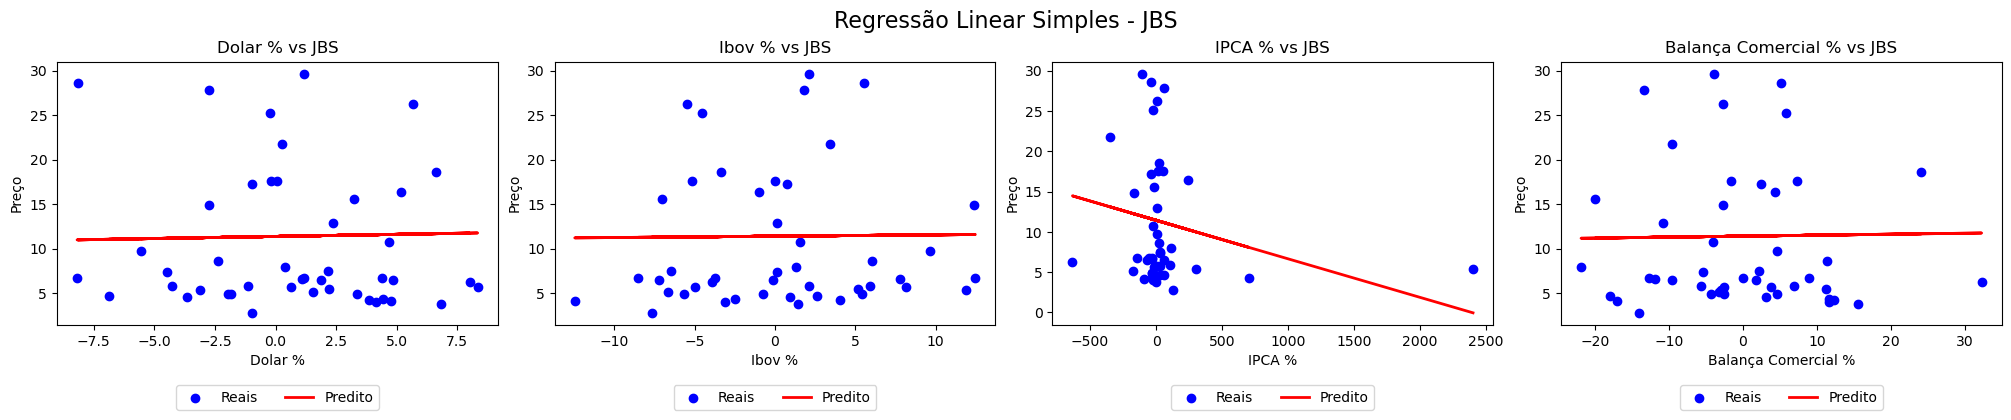


🔹🔹🔹 Regressão Linear Simples para Marfrig 🔹🔹🔹

📈 Variável: Dolar %
  R² teste: -0.0104
  EMA: 3.07
  EQM: 13.64

📈 Variável: Ibov %
  R² teste: -0.0047
  EMA: 3.07
  EQM: 13.56

📈 Variável: IPCA %
  R² teste: -0.0104
  EMA: 3.04
  EQM: 13.64

📈 Variável: Balança Comercial %
  R² teste: -0.0040
  EMA: 3.07
  EQM: 13.55


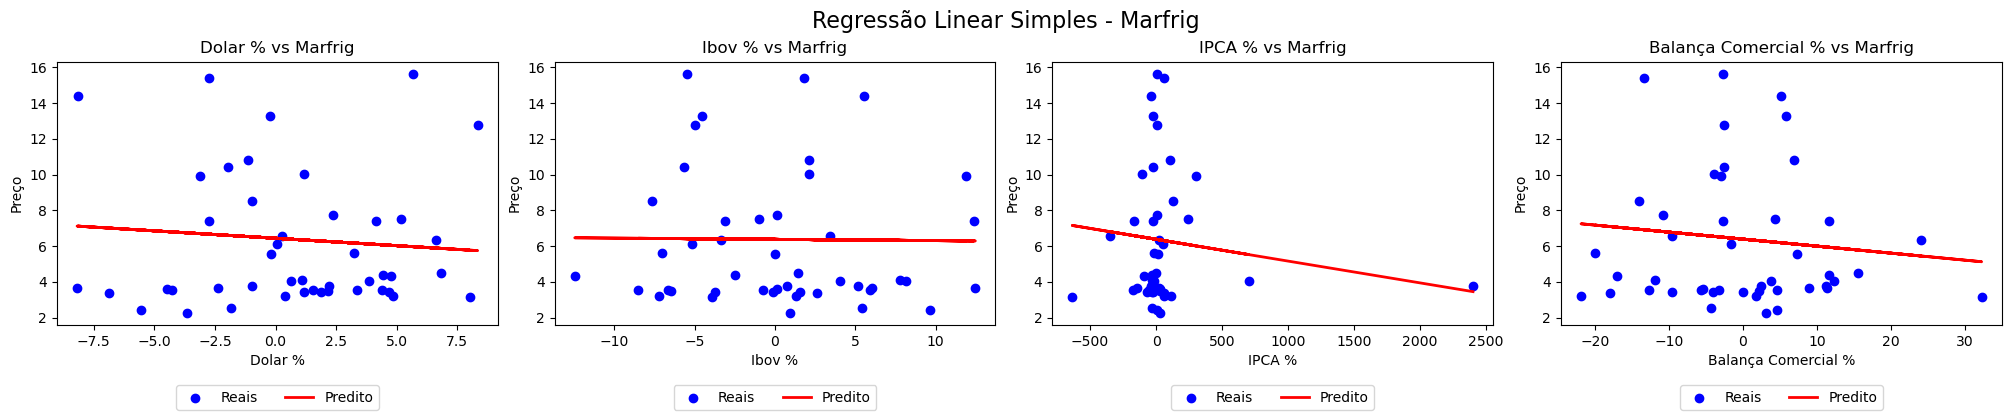


🔹🔹🔹 Regressão Linear Simples para BRF 🔹🔹🔹

📈 Variável: Dolar %
  R² teste: 0.0020
  EMA: 1.61
  EQM: 4.22

📈 Variável: Ibov %
  R² teste: -0.0148
  EMA: 1.62
  EQM: 4.30

📈 Variável: IPCA %
  R² teste: -0.0377
  EMA: 1.64
  EQM: 4.39

📈 Variável: Balança Comercial %
  R² teste: -0.0162
  EMA: 1.63
  EQM: 4.30


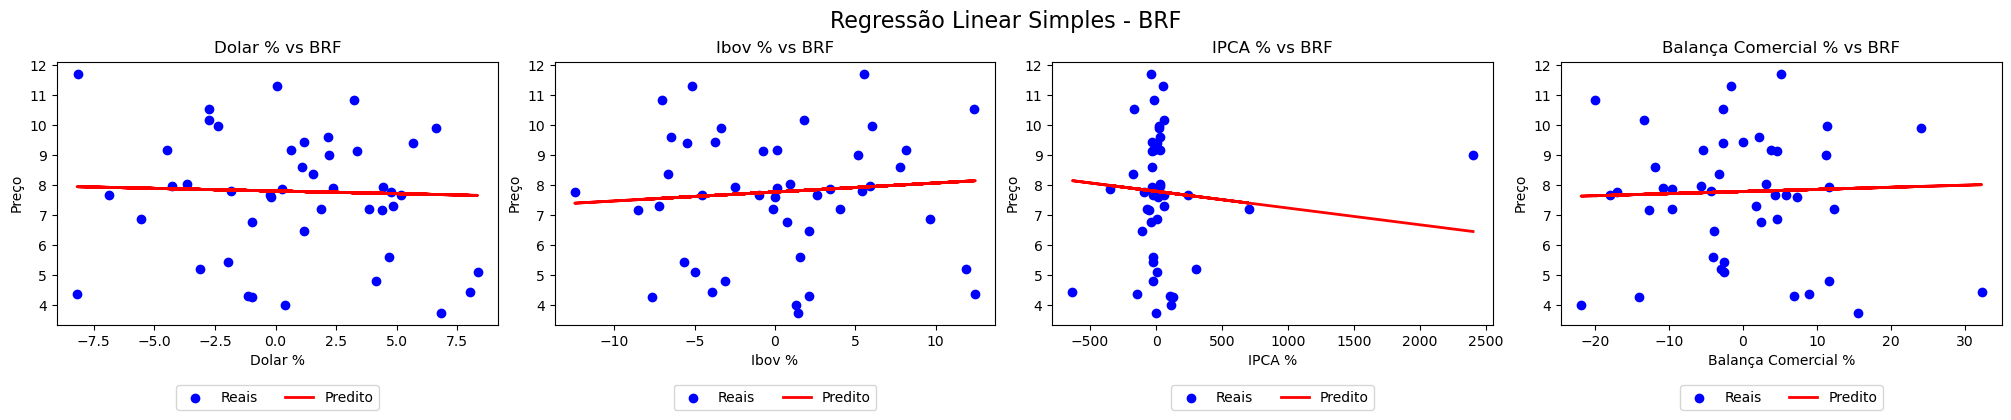

In [24]:
# Dicionário com os dados de cada empresa
empresas = {
    'JBS': (y_jbs_train, y_jbs_test),
    'Marfrig': (y_marfrig_train, y_marfrig_test),
    'BRF': (y_brf_train, y_brf_test)
}

# Para cada empresa
for nome_empresa, (y_train, y_test) in empresas.items():
    print(f"\n🔹🔹🔹 Regressão Linear Simples para {nome_empresa} 🔹🔹🔹")

    variaveis = X_train.columns.tolist()
    n_vars = len(variaveis)

    # Criar subplots (1 linha, n colunas)
    fig, axs = plt.subplots(1, n_vars, figsize=(5 * n_vars, 4), constrained_layout=True)

    for i, col in enumerate(variaveis):
        X_s_train = X_train[[col]]
        X_s_test = X_test[[col]]

        modelo = LinearRegression().fit(X_s_train, y_train)
        y_pred = modelo.predict(X_s_test)

        # Avaliação
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        print(f"\n📈 Variável: {col}")
        print(f"  R² teste: {r2:.4f}")
        print(f"  EMA: {mae:.2f}")
        print(f"  EQM: {mse:.2f}")

        # Plot no subplot correspondente
        ax = axs[i]
        ax.scatter(X_s_test, y_test, color='blue', label='Reais')
        ax.plot(X_s_test, y_pred, color='red', linewidth=2, label='Predito')
        ax.set_xlabel(col)
        ax.set_ylabel("Preço")
        ax.set_title(f"{col} vs {nome_empresa}")
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)

    # Título geral
    fig.suptitle(f"Regressão Linear Simples - {nome_empresa}", fontsize=16)
    plt.show()


### regressao linear multipla


🔷🔷🔷 Regressão Linear Múltipla para JBS 🔷🔷🔷

📈 JBS - Variáveis: ('Dolar %', 'Ibov %')
  R² treino: 0.23%
  R² teste: -2.41%
  EMA: 6.66
  EQM: 59.40

📈 JBS - Variáveis: ('Dolar %', 'IPCA %')
  R² treino: 2.93%
  R² teste: 0.03%
  EMA: 6.59
  EQM: 57.98

📈 JBS - Variáveis: ('Dolar %', 'Balança Comercial %')
  R² treino: 0.08%
  R² teste: -1.95%
  EMA: 6.65
  EQM: 59.14

📈 JBS - Variáveis: ('Ibov %', 'IPCA %')
  R² treino: 2.95%
  R² teste: 0.47%
  EMA: 6.59
  EQM: 57.73

📈 JBS - Variáveis: ('Ibov %', 'Balança Comercial %')
  R² treino: 0.04%
  R² teste: -1.43%
  EMA: 6.66
  EQM: 58.83

📈 JBS - Variáveis: ('IPCA %', 'Balança Comercial %')
  R² treino: 2.92%
  R² teste: 0.28%
  EMA: 6.60
  EQM: 57.84

📈 JBS - Variáveis: ('Dolar %', 'Ibov %', 'IPCA %')
  R² treino: 3.09%
  R² teste: -0.12%
  EMA: 6.58
  EQM: 58.07

📈 JBS - Variáveis: ('Dolar %', 'Ibov %', 'Balança Comercial %')
  R² treino: 0.24%
  R² teste: -2.56%
  EMA: 6.66
  EQM: 59.49

📈 JBS - Variáveis: ('Dolar %', 'IPCA %', 'Balança

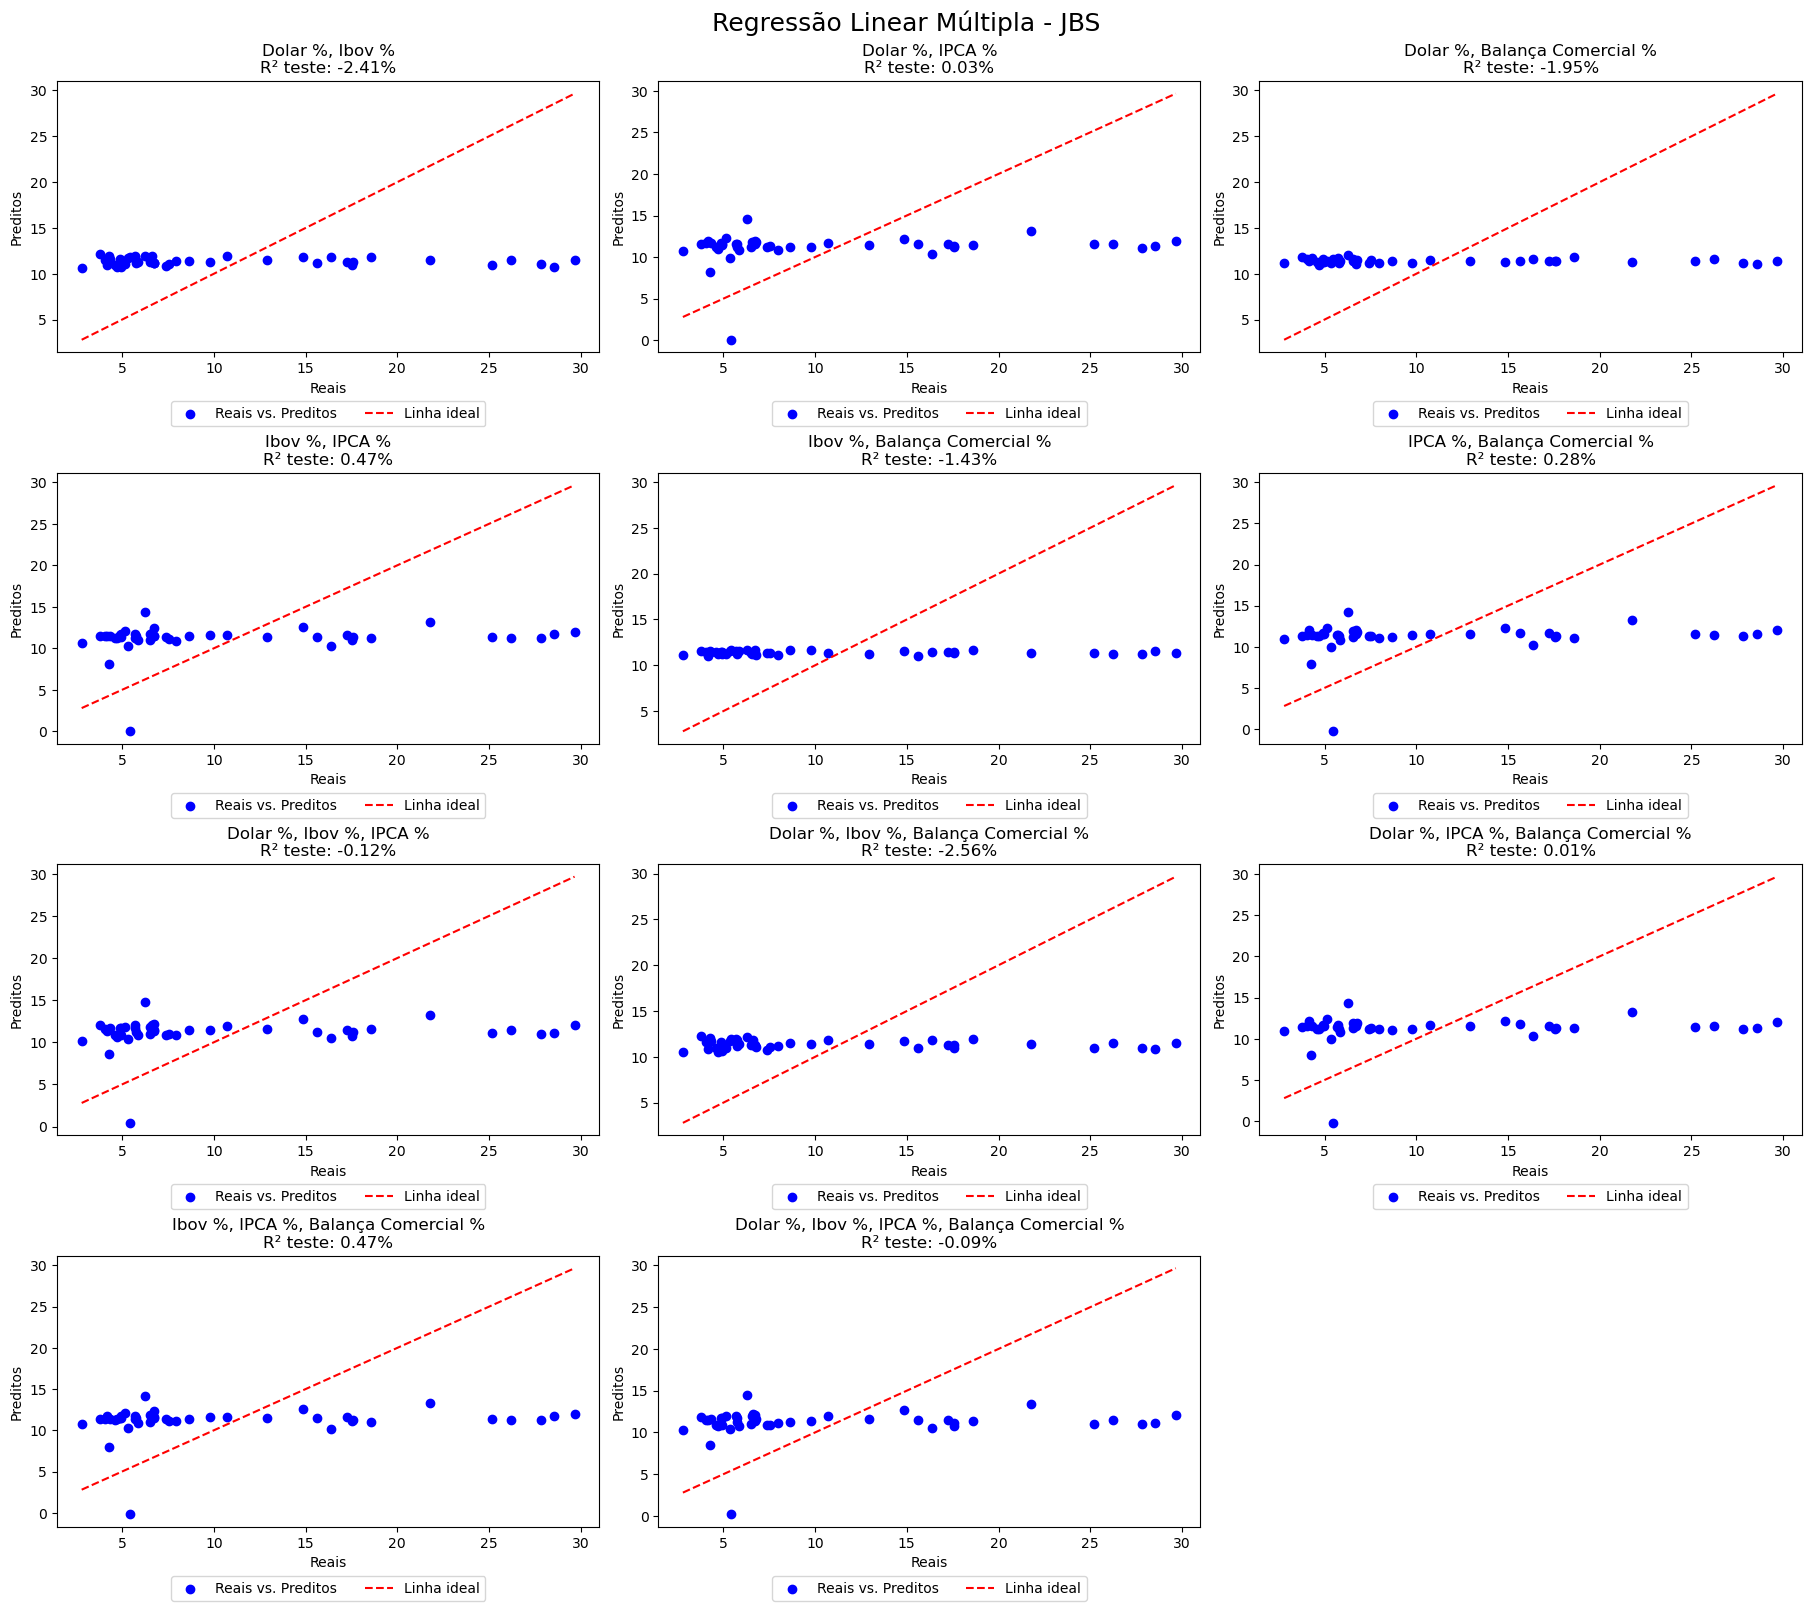


🔷🔷🔷 Regressão Linear Múltipla para Marfrig 🔷🔷🔷

📈 Marfrig - Variáveis: ('Dolar %', 'Ibov %')
  R² treino: 2.93%
  R² teste: 0.14%
  EMA: 3.08
  EQM: 13.48

📈 Marfrig - Variáveis: ('Dolar %', 'IPCA %')
  R² treino: 2.81%
  R² teste: -1.77%
  EMA: 3.06
  EQM: 13.73

📈 Marfrig - Variáveis: ('Dolar %', 'Balança Comercial %')
  R² treino: 2.70%
  R² teste: -0.94%
  EMA: 3.08
  EQM: 13.62

📈 Marfrig - Variáveis: ('Ibov %', 'IPCA %')
  R² treino: 1.20%
  R² teste: -0.95%
  EMA: 3.04
  EQM: 13.62

📈 Marfrig - Variáveis: ('Ibov %', 'Balança Comercial %')
  R² treino: 1.72%
  R² teste: -0.20%
  EMA: 3.07
  EQM: 13.52

📈 Marfrig - Variáveis: ('IPCA %', 'Balança Comercial %')
  R² treino: 3.35%
  R² teste: -1.89%
  EMA: 3.10
  EQM: 13.75

📈 Marfrig - Variáveis: ('Dolar %', 'Ibov %', 'IPCA %')
  R² treino: 4.32%
  R² teste: -1.19%
  EMA: 3.08
  EQM: 13.66

📈 Marfrig - Variáveis: ('Dolar %', 'Ibov %', 'Balança Comercial %')
  R² treino: 4.26%
  R² teste: -0.56%
  EMA: 3.08
  EQM: 13.57

📈 Marfrig -

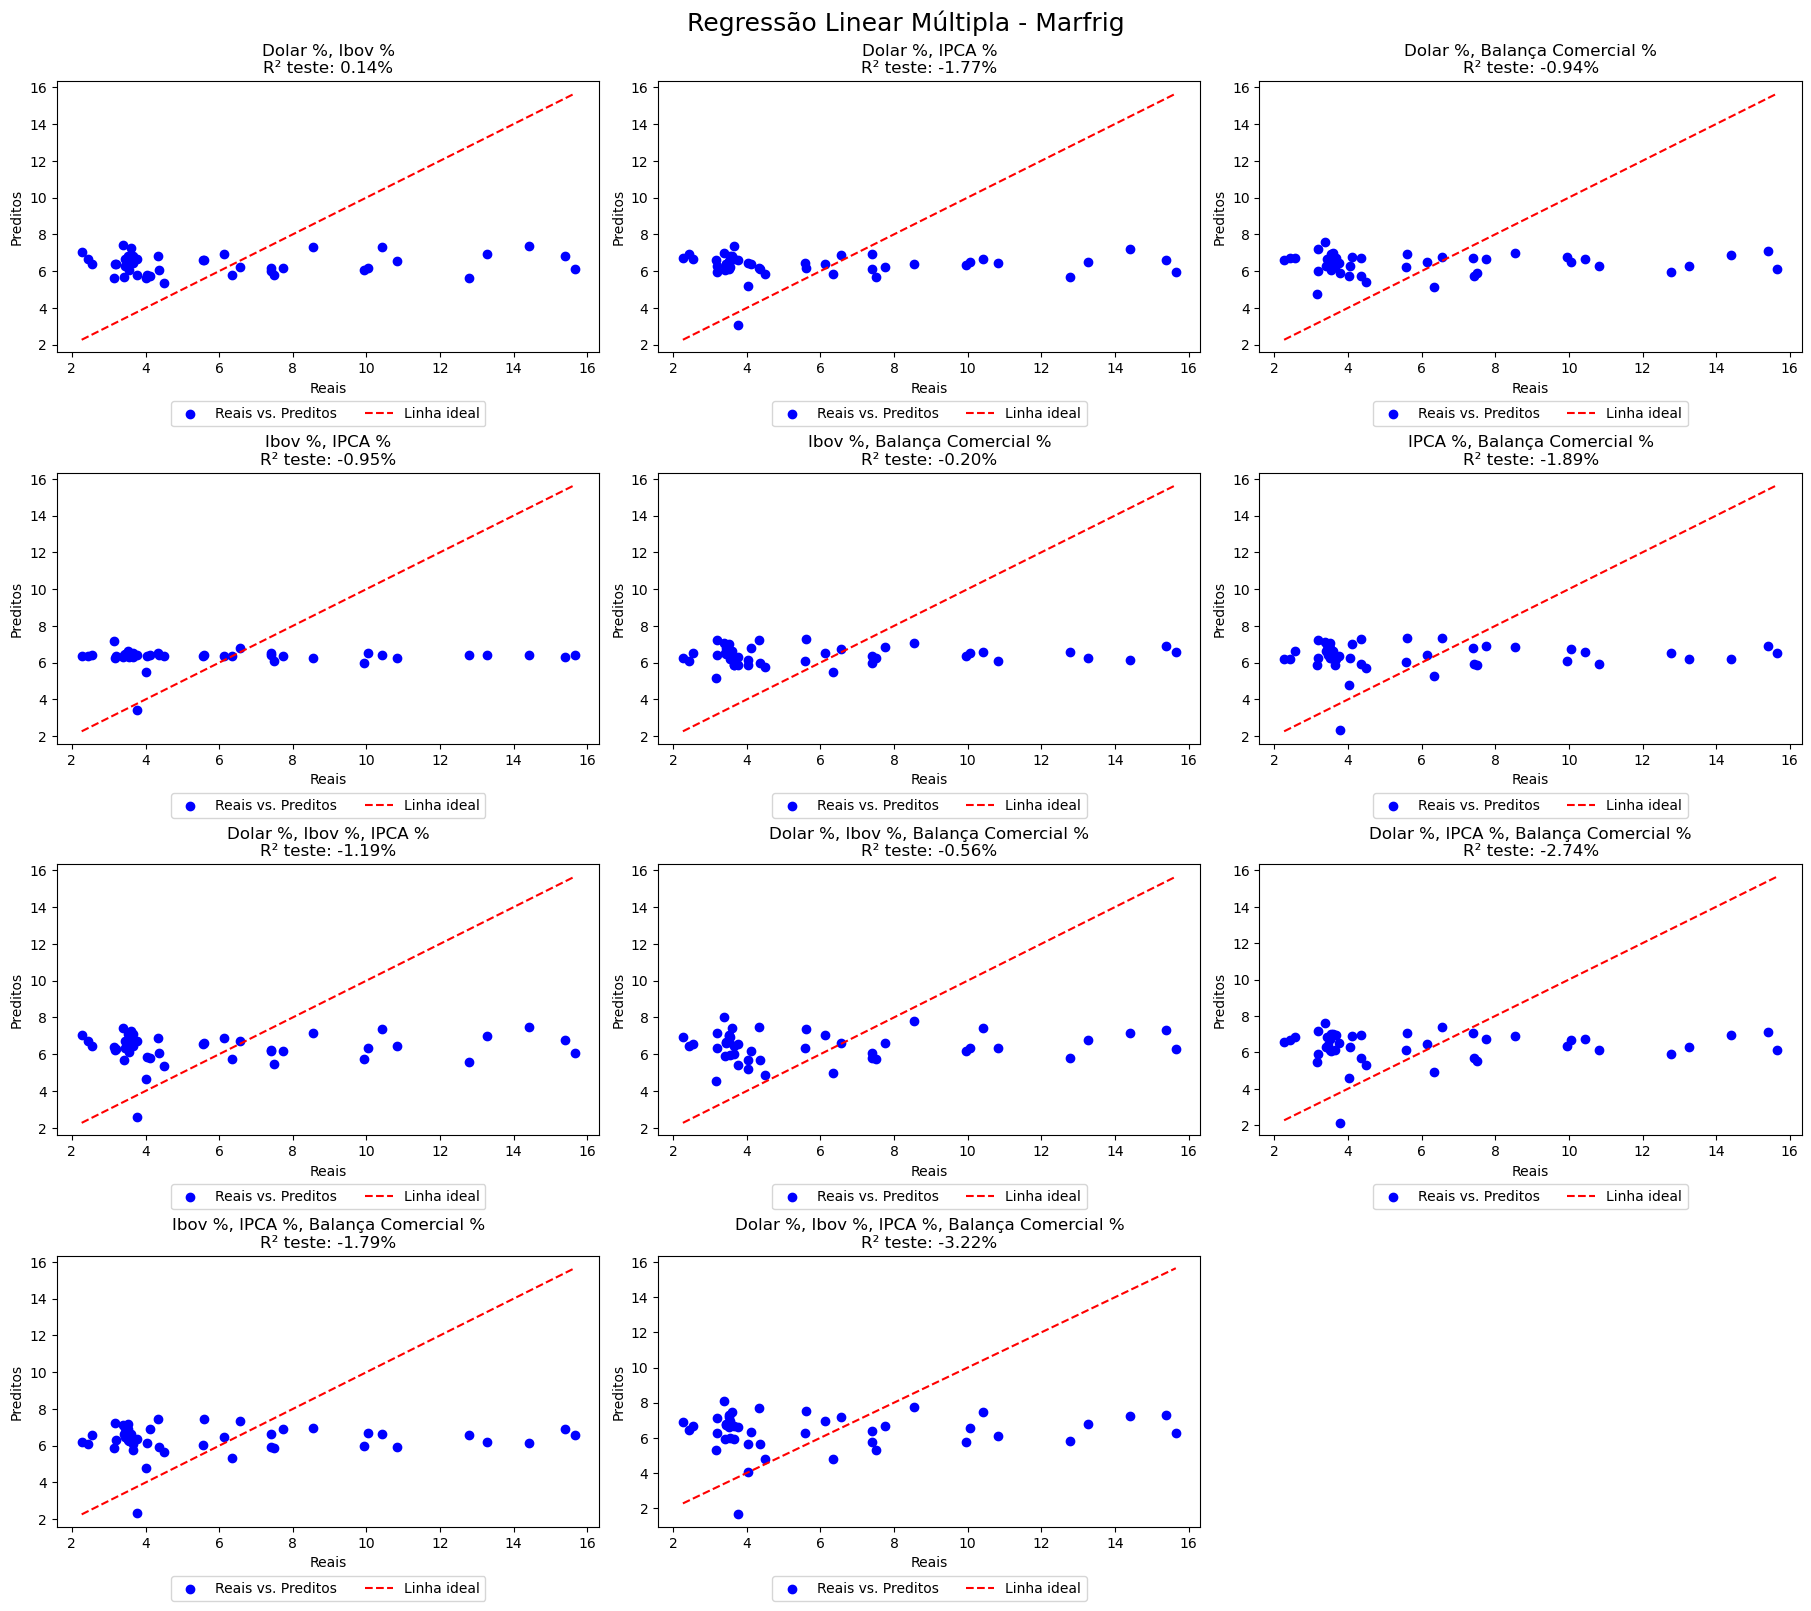


🔷🔷🔷 Regressão Linear Múltipla para BRF 🔷🔷🔷

📈 BRF - Variáveis: ('Dolar %', 'Ibov %')
  R² treino: 0.80%
  R² teste: -2.76%
  EMA: 1.63
  EQM: 4.35

📈 BRF - Variáveis: ('Dolar %', 'IPCA %')
  R² treino: 0.65%
  R² teste: -2.86%
  EMA: 1.64
  EQM: 4.35

📈 BRF - Variáveis: ('Dolar %', 'Balança Comercial %')
  R² treino: 0.26%
  R² teste: -0.62%
  EMA: 1.62
  EQM: 4.26

📈 BRF - Variáveis: ('Ibov %', 'IPCA %')
  R² treino: 1.27%
  R² teste: -4.50%
  EMA: 1.65
  EQM: 4.42

📈 BRF - Variáveis: ('Ibov %', 'Balança Comercial %')
  R² treino: 0.89%
  R² teste: -2.80%
  EMA: 1.63
  EQM: 4.35

📈 BRF - Variáveis: ('IPCA %', 'Balança Comercial %')
  R² treino: 0.53%
  R² teste: -4.08%
  EMA: 1.64
  EQM: 4.41

📈 BRF - Variáveis: ('Dolar %', 'Ibov %', 'IPCA %')
  R² treino: 1.33%
  R² teste: -5.43%
  EMA: 1.66
  EQM: 4.46

📈 BRF - Variáveis: ('Dolar %', 'Ibov %', 'Balança Comercial %')
  R² treino: 0.95%
  R² teste: -3.92%
  EMA: 1.64
  EQM: 4.40

📈 BRF - Variáveis: ('Dolar %', 'IPCA %', 'Balança Come

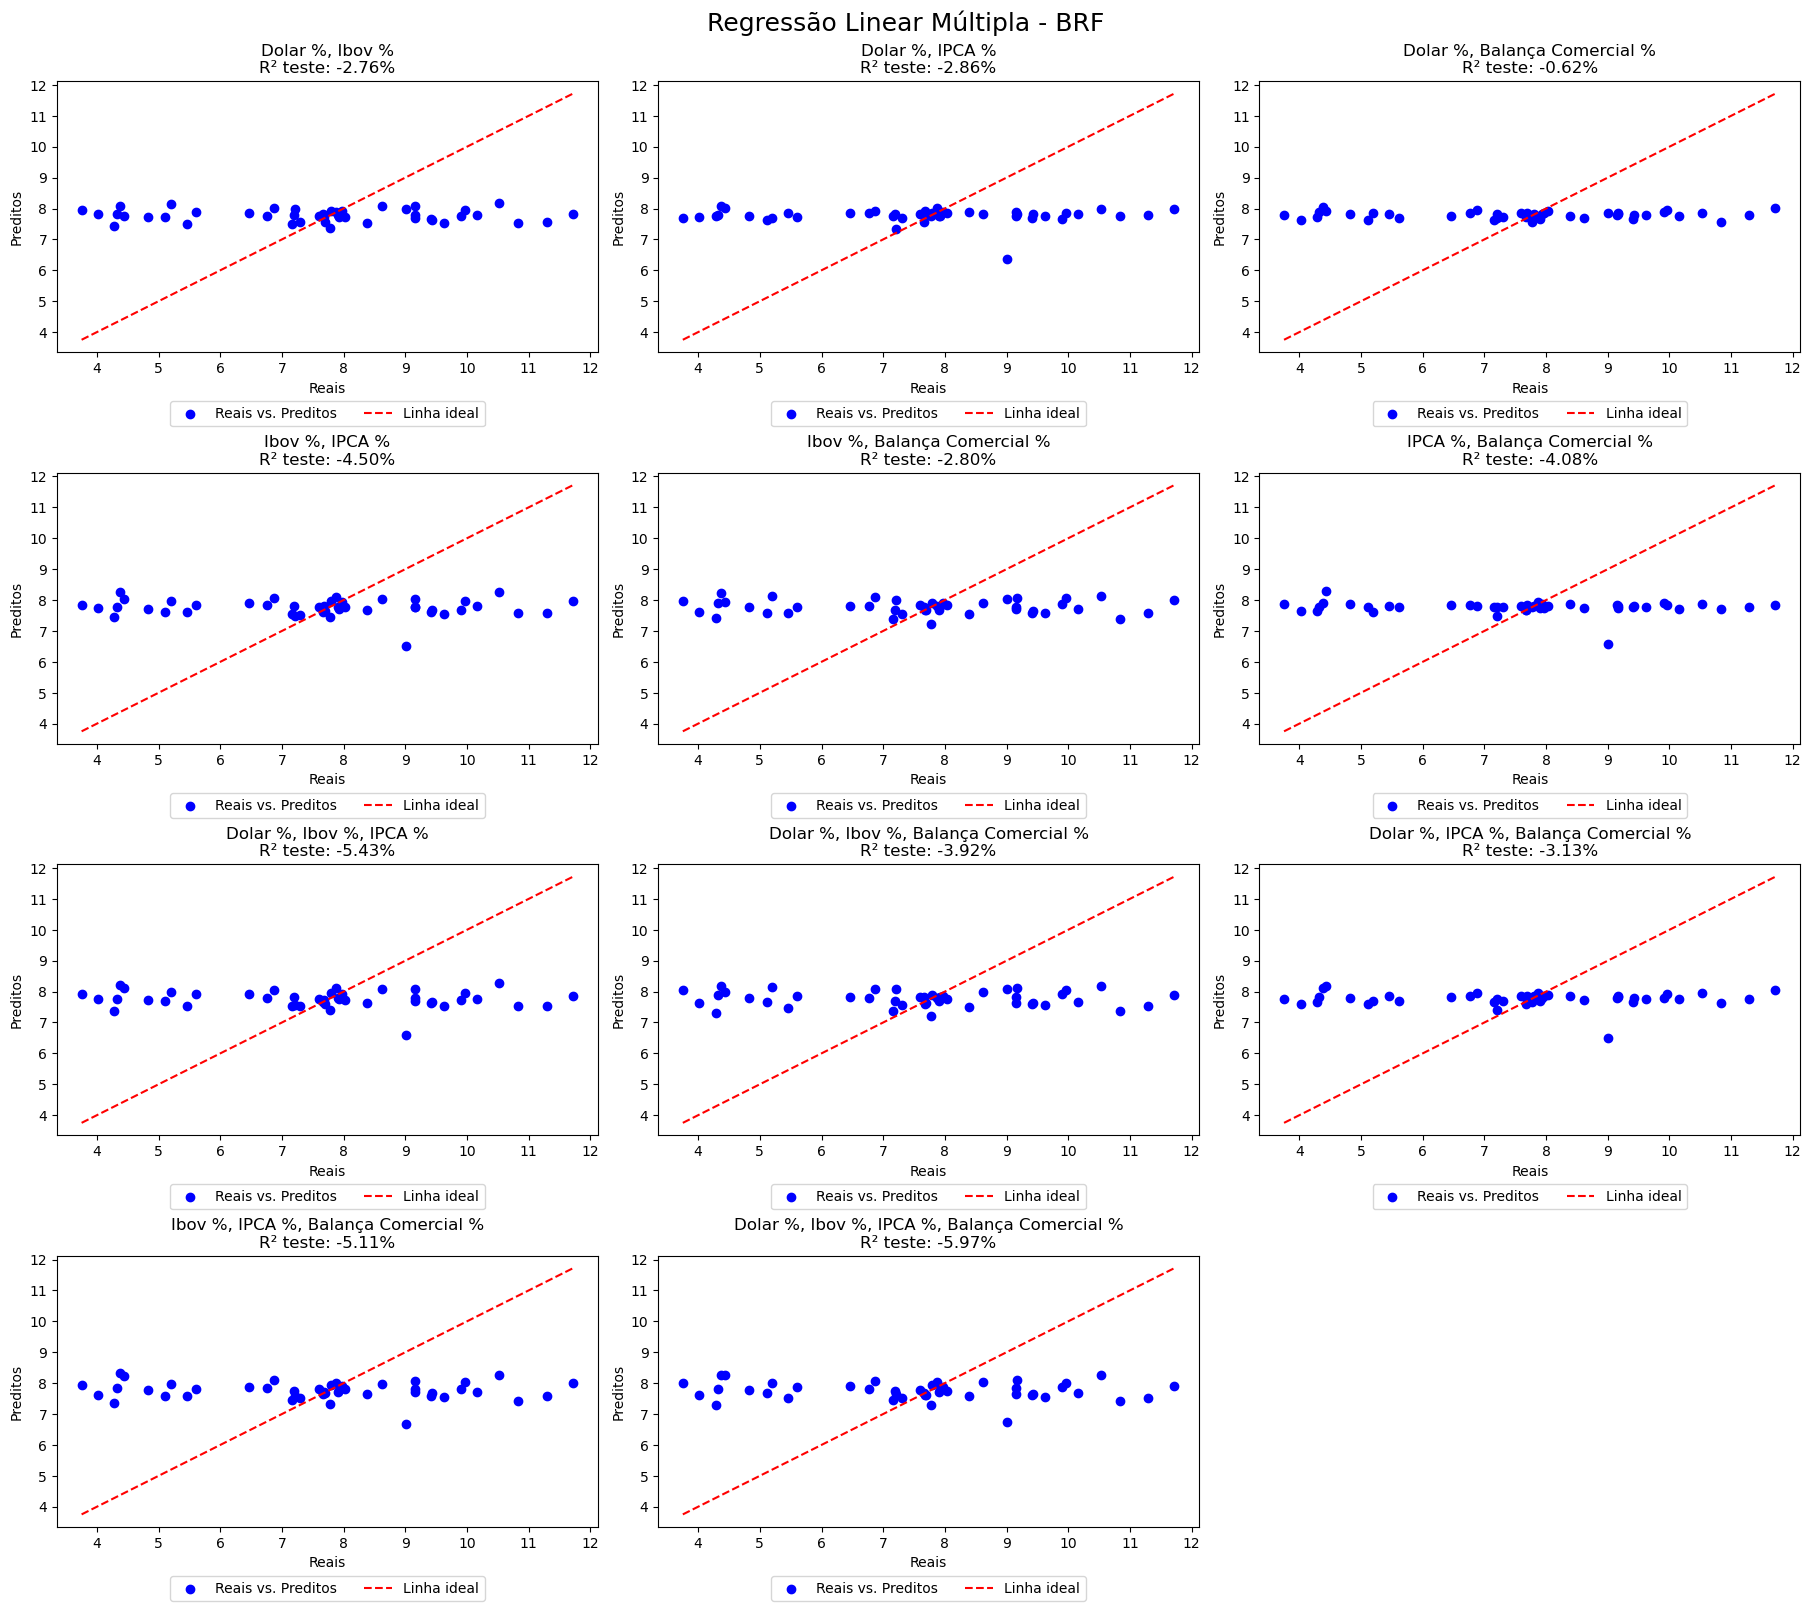

In [25]:
#dados de saída de cada empresa
empresas = {
    'JBS': (y_jbs_train, y_jbs_test),
    'Marfrig': (y_marfrig_train, y_marfrig_test),
    'BRF': (y_brf_train, y_brf_test)
}

#loop para cada empresa
for nome_empresa, (y_train, y_test) in empresas.items():
    print(f"\n🔷🔷🔷 Regressão Linear Múltipla para {nome_empresa} 🔷🔷🔷")

    #gerar todas as combinações de 2 a 4 variáveis
    combinacoes = []
    for k in range(2, len(X_train.columns) + 1):
        combinacoes.extend(list(combinations(X_train.columns, k)))

    n_combos = len(combinacoes)
    n_cols = 3  # número de gráficos por linha
    n_rows = math.ceil(n_combos / n_cols)

    # Criar subplots para todos os gráficos dessa empresa
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), constrained_layout=True)
    axs = axs.flatten()  # achata a matriz para indexação simples

    #loop pelas combinações
    for idx, combo in enumerate(combinacoes):
        X_mult_train = X_train[list(combo)]
        X_mult_test = X_test[list(combo)]

        modelo = LinearRegression().fit(X_mult_train, y_train)
        y_pred = modelo.predict(X_mult_test)

        #avaliação
        r2_treino = modelo.score(X_mult_train, y_train)
        r2_teste = modelo.score(X_mult_test, y_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        #impressão das métricas no terminal
        print(f"\n📈 {nome_empresa} - Variáveis: {combo}")
        print(f"  R² treino: {r2_treino * 100:.2f}%")
        print(f"  R² teste: {r2_teste * 100:.2f}%")
        print(f"  EMA: {mae:.2f}")
        print(f"  EQM: {mse:.2f}")

        #gráfico no subplot correspondente
        ax = axs[idx]
        ax.scatter(y_test, y_pred, color='blue', label='Reais vs. Preditos')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Linha ideal')
        ax.set_xlabel("Reais")
        ax.set_ylabel("Preditos")
        ax.set_title(f"{', '.join(combo)}\nR² teste: {r2_teste*100:.2f}%")
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=2)

    #apagar subplots vazios
    for j in range(idx + 1, len(axs)):
        fig.delaxes(axs[j])

    #título geral
    fig.suptitle(f"Regressão Linear Múltipla - {nome_empresa}", fontsize=18)
    plt.show()
